# Sales Prediction Demo Notebook

A Jupyter notebook for demonstrating the Sales Prediction Web App functionality, aligned with the requested structure.

This notebook will:
- Verify environment and required files
- Load the scaler and any available models (LightGBM, CatBoost, Ridge, optionally XGBoost)
- Show feature engineering for date-based inputs
- Run a single prediction example
- Compute performance metrics (R2, RMSE, RMSPE) for available models
- Run a batch prediction example and save a predictions CSV


## 1. Setup Environment

- Ensure the following files exist in either this folder or the Case2 project folder:
  - `scaler.pkl`
  - Model files (any subset): `lgbm_model.pkl`, `catboost_model.pkl`, `ridge_model.pkl`, and optionally `xgb_model.pkl` or `xgboost_model.pkl`
- Optional inputs:
  - `train2.csv` for evaluation metrics
  - `test.csv` for batch prediction demo

We will use the same library stack as the web app.

In [7]:
# Auto-install required libraries if missing.
# This makes the notebook self-contained once a Python kernel is selected.
import sys, subprocess

def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        __import__(name)
        print(f"{pkg} is available")
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        __import__(name)
        print(f"{pkg} installed")

for pkg, imp in [
    ("numpy", "numpy"),
    ("pandas", "pandas"),
    ("scikit-learn", "sklearn"),
    ("lightgbm", "lightgbm"),
    ("catboost", "catboost"),
    ("xgboost", "xgboost"),
]:
    ensure(pkg, imp)

import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display

print("\nPython OK. Versions:")
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

# Define search paths for artifacts
NB_DIR = Path.cwd()
# Also search the Case2 project folder where your artifacts exist
CASE2_DIR = Path('/Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2')
UPLOADS_DIR = (NB_DIR / 'uploads')
UPLOADS_DIR.mkdir(exist_ok=True)

ARTIFACT_CANDIDATE_DIRS = [NB_DIR, CASE2_DIR]

# Supported model filenames (multiple options for XGBoost)
MODEL_FILES = {
    'lightgbm': ['lgbm_model.pkl'],
    'catboost': ['catboost_model.pkl'],
    'ridge': ['ridge_model.pkl'],
    'xgboost': ['xgb_model.pkl', 'xgboost_model.pkl']
}

# Helper to find a file in candidate directories
def find_file(filename):
    for base in ARTIFACT_CANDIDATE_DIRS:
        p = base / filename
        if p.exists():
            return p
    return None


numpy is available
pandas is available
scikit-learn is available
lightgbm is available
catboost is available
xgboost is available

Python OK. Versions:
numpy: 2.3.3
pandas: 2.3.3


## 2. Load Pre-trained Models

Load the scaler and any available models. Some models (e.g., LightGBM/CatBoost/XGBoost) require their packages installed to unpickle successfully.

In [8]:
# Load scaler
scaler_path = find_file('scaler.pkl')
if scaler_path is None:
    raise FileNotFoundError("scaler.pkl not found in this or the Case2 folder")
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
print("Loaded scaler from:", scaler_path)

# Load models dynamically
models = {}
for key, candidates in MODEL_FILES.items():
    for fname in candidates:
        p = find_file(fname)
        if p is not None:
            try:
                with open(p, 'rb') as f:
                    models[key] = pickle.load(f)
                print(f"Loaded model {key} from: {p}")
                break
            except Exception as e:
                print(f"WARNING: Failed to load {fname}: {e}")

if not models:
    print("WARNING: No models loaded. Add any of:", sum(MODEL_FILES.values(), []))
else:
    print("Available models:", list(models.keys()))


Loaded scaler from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/scaler.pkl
Loaded model lightgbm from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/lgbm_model.pkl
Loaded model catboost from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/catboost_model.pkl
Loaded model ridge from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/ridge_model.pkl
Available models: ['lightgbm', 'catboost', 'ridge']


## 3. Feature Engineering for Predictions

From an input `date` we derive:
- `month`, `day`, `dayofweek`, `dayofyear`, `weekofyear`

Feature order expected by the scaler/models:
`[store, item, month, day, dayofweek, dayofyear, weekofyear]`.

In [9]:
def make_features(store: int, item: int, date: pd.Timestamp):
    date = pd.to_datetime(date)
    month = date.month
    day = date.day
    dayofweek = date.dayofweek
    dayofyear = date.dayofyear
    weekofyear = int(date.isocalendar().week)
    return [store, item, month, day, dayofweek, dayofyear, weekofyear]

# Quick example
print("Example features:", make_features(1, 1, '2024-06-15'))


Example features: [1, 1, 6, 15, 5, 167, 24]


## 4. Single Prediction Example + Metrics

Runs a single prediction with the first available model and computes metrics (R2, RMSE, RMSPE) on a holdout split (last 20%) of `train2.csv` if available.

In [10]:
from sklearn.metrics import r2_score, mean_squared_error

if not models:
    print("No models available to run a single prediction.")
else:
    # Choose default model: prefer lightgbm, else first available
    preferred = ['lightgbm', 'catboost', 'xgboost', 'ridge']
    chosen_key = next((k for k in preferred if k in models), next(iter(models.keys())))
    model = models[chosen_key]

    store_id = 1
    item_id = 1
    date = pd.to_datetime('2024-06-15')

    feats = make_features(store_id, item_id, date)
    scaled = scaler.transform([feats])
    y_pred = model.predict(scaled)
    y_pred_round = int(np.round(np.ravel(y_pred)[0]))

    print(f"Model: {chosen_key}")
    print("Features:", feats)
    print("Predicted sales:", y_pred_round)

    # Metrics on holdout from train2.csv
    train2_path = find_file('train2.csv')
    if train2_path is None:
        print("train2.csv not found. Skipping evaluation metrics.")
    else:
        print("\nEvaluating models on holdout split from:", train2_path)
        df_full = pd.read_csv(train2_path, parse_dates=['date'])
        required_cols = {'date', 'store', 'item', 'sales'}
        if not required_cols.issubset(df_full.columns):
            print("train2.csv missing required columns, skipping evaluation.")
        else:
            # Feature engineering
            df_full['month'] = df_full['date'].dt.month
            df_full['day'] = df_full['date'].dt.day
            df_full['dayofweek'] = df_full['date'].dt.dayofweek
            df_full['dayofyear'] = df_full['date'].dt.dayofyear
            df_full['weekofyear'] = df_full['date'].dt.isocalendar().week.astype(int)

            feature_cols = ['store', 'item', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
            df_full = df_full.sort_values('date').reset_index(drop=True)
            n = len(df_full)
            n_test = max(1, int(0.2 * n))
            test_df = df_full.iloc[-n_test:]

            X_test = test_df[feature_cols]
            y_test = test_df['sales'].to_numpy()
            X_test_scaled = scaler.transform(X_test)

            def rmspe(y_true, y_pred):
                y_true = np.asarray(y_true)
                y_pred = np.asarray(y_pred)
                eps = 1e-8
                mask = y_true != 0
                if not np.any(mask):
                    return np.nan
                pe = (y_pred[mask] - y_true[mask]) / (y_true[mask] + eps)
                return float(np.sqrt(np.mean(pe ** 2)) * 100.0)

            rows = []
            for key, mdl in models.items():
                try:
                    pred = mdl.predict(X_test_scaled)
                    pred = np.ravel(pred)
                    r2 = float(r2_score(y_test, pred))
                    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
                    rmspe_val = rmspe(y_test, pred)
                    rows.append({
                        'Model': key.replace('_', ' ').title(),
                        'R2 Score (Test)': round(r2, 4),
                        'RMSE (Test)': round(rmse, 4),
                        'RMSPE (Test)': (None if np.isnan(rmspe_val) else f"{rmspe_val:.2f}%"),
                    })
                except Exception as e:
                    rows.append({
                        'Model': key.replace('_', ' ').title(),
                        'R2 Score (Test)': 'Error',
                        'RMSE (Test)': 'Error',
                        'RMSPE (Test)': f'Error: {e}',
                    })

            if rows:
                import pandas as _pd
                metrics_df = _pd.DataFrame(rows)[['Model', 'R2 Score (Test)', 'RMSE (Test)', 'RMSPE (Test)']]
                # Sort by RMSE ascending where numeric
                def _sort_key(v):
                    try:
                        return float(v)
                    except:
                        return np.inf
                metrics_df['_rmse_sort'] = metrics_df['RMSE (Test)'].apply(_sort_key)
                metrics_df = metrics_df.sort_values('_rmse_sort').drop(columns=['_rmse_sort']).reset_index(drop=True)

                out_path = UPLOADS_DIR / 'model_metrics.csv'
                metrics_df.to_csv(out_path, index=False)
                print("\nMetrics (saved to", out_path, "):")
                display(metrics_df)
            else:
                print("No metrics computed.")


Model: lightgbm
Features: [1, 1, 6, 15, 5, 167, 24]
Predicted sales: 28

Evaluating models on holdout split from: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/train2.csv

Metrics (saved to /Users/ayush/Downloads/Sales Uplift 2/uploads/model_metrics.csv ):


Model  R2 Score (Test)  RMSE (Test) RMSPE (Test)
0  Catboost           0.9010       9.9261       17.99%
1  Lightgbm           0.8685      11.4415       18.99%
2     Ridge           0.0605      30.5791       85.03%

## 5. Batch Prediction Example

Load `test.csv` from this folder or the Case2 folder. The file must contain columns: `date`, `store`, `item`. We will write the output to `uploads/predictions_test_notebook.csv`.

In [11]:
# Locate a test.csv
cand = find_file('test.csv')
if cand is None:
    print("No test.csv found. Create one with columns: date, store, item.")
else:
    print("Using test.csv:", cand)

if cand is not None and models:
    df = pd.read_csv(cand, parse_dates=['date'])
    required = {'date', 'store', 'item'}
    if not required.issubset(df.columns):
        raise ValueError(f"test.csv must contain columns: {sorted(required)}")

    # Feature engineering
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)

    feature_cols = ['store', 'item', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear']
    X = df[feature_cols]
    X_scaled = scaler.transform(X)

    # Choose default model for batch: prefer lightgbm, else first available
    preferred = ['lightgbm', 'catboost', 'xgboost', 'ridge']
    model_key = next((k for k in preferred if k in models), next(iter(models.keys())))
    model = models[model_key]

    preds = model.predict(X_scaled)
    df['predicted_sales'] = np.round(np.ravel(preds)).astype(int)

    out_path = UPLOADS_DIR / 'predictions_test_notebook.csv'
    df.to_csv(out_path, index=False)
    print("Wrote:", out_path)


Using test.csv: /Users/ayush/Downloads/Case2-Nosalesuplift(pipeline) 2/test.csv
Wrote: /Users/ayush/Downloads/Sales Uplift 2/uploads/predictions_test_notebook.csv


In [12]:
import warnings
warnings.filterwarnings("ignore")

import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import pickle

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# from google.colab import files
# uploaded = files.upload()


In [ ]:
import pandas as pd
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
store = pd.read_csv(io.BytesIO(uploaded['store.csv']))

In [ ]:
test_df = pd.read_csv('test.csv')


In [ ]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [ ]:
store.tail()

Store StoreType Assortment  CompetitionDistance  \
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec

In [ ]:
store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [ ]:
# total number of rows
total_rows = store.shape[0]

# total number of duplicate rows
duplicate_rows = store.duplicated().sum()

print(f"Total number of rows in store dataset: {total_rows}")
print(f"Total number of duplicate rows in store dataset: {duplicate_rows}")

Total number of rows in store dataset: 1115
Total number of duplicate rows in store dataset: 0


In [ ]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
# Unique values in each column
print(store.apply(lambda col: col.unique()))

Store                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
StoreType                                                         [c, a, d, b]
Assortment                                                           [a, c, b]
CompetitionDistance          [1270.0, 570.0, 14130.0, 620.0, 29910.0, 310.0...
CompetitionOpenSinceMonth    [9.0, 11.0, 12.0, 4.0, 10.0, 8.0, nan, 3.0, 6....
CompetitionOpenSinceYear     [2008.0, 2007.0, 2006.0, 2009.0, 2015.0, 2013....
Promo2                                                                  [0, 1]
Promo2SinceWeek              [nan, 13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0,...
Promo2SinceYear              [nan, 2010.0, 2011.0, 2012.0, 2009.0, 2014.0, ...
PromoInterval                [nan, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Ju...
dtype: object


# **TRAIN**

In [ ]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [ ]:
train.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

In [ ]:
# total number of rows
total_rows = train.shape[0]

# total number of duplicate rows
duplicate_rows = train.duplicated().sum()

print(f"Total number of rows in train dataset: {total_rows}")
print(f"Total number of duplicate rows in train dataset: {duplicate_rows}")

Total number of rows in train dataset: 1017209
Total number of duplicate rows in train dataset: 0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
# Unique values in each column
print(train.apply(lambda col: col.unique()))

Store            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
DayOfWeek                                    [5, 4, 3, 2, 1, 7, 6]
Date             [2015-07-31, 2015-07-30, 2015-07-29, 2015-07-2...
Sales            [5263, 6064, 8314, 13995, 4822, 5651, 15344, 8...
Customers        [555, 625, 821, 1498, 559, 589, 1414, 833, 687...
Open                                                        [1, 0]
Promo                                                       [1, 0]
StateHoliday                                       [0, a, b, c, 0]
SchoolHoliday                                               [1, 0]
dtype: object


# **DATA CLEANING**

In [ ]:
#  number and percent of missing values in each column

# number of missing values per column
missing_values = store.isnull().sum()

# percentage of missing values per column
missing_percentage = (missing_values / store.shape[0]) * 100

missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print(missing_data_summary)

                           Missing Values  Percentage (%)
Store                                   0        0.000000
StoreType                               0        0.000000
Assortment                              0        0.000000
CompetitionDistance                     3        0.269058
CompetitionOpenSinceMonth             354       31.748879
CompetitionOpenSinceYear              354       31.748879
Promo2                                  0        0.000000
Promo2SinceWeek                       544       48.789238
Promo2SinceYear                       544       48.789238
PromoInterval                         544       48.789238


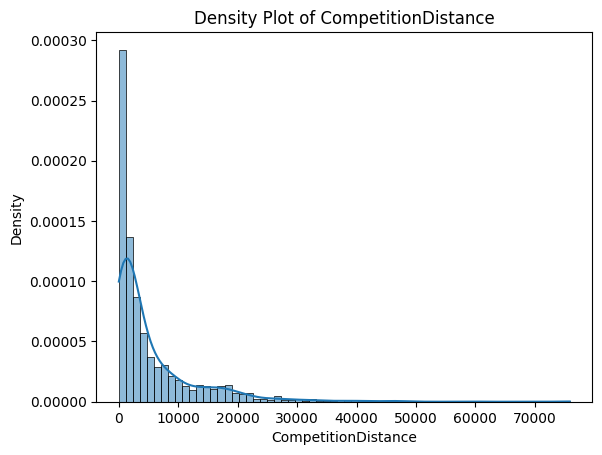

In [ ]:
#  density plot for CompetitionDistance
sns.histplot(store['CompetitionDistance'], kde=True, stat="density")
plt.xlabel('CompetitionDistance')
plt.ylabel('Density')
plt.title('Density Plot of CompetitionDistance')
plt.show()


In [ ]:
# filling the missing values with median
store["CompetitionDistance"].fillna(value = store.CompetitionDistance.median(), inplace=True)

In [ ]:
#  number and percent of missing values in each column

# number of missing values per column
missing_values = store.isnull().sum()

# percentage of missing values per column
missing_percentage = (missing_values / store.shape[0]) * 100

missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print(missing_data_summary)

                           Missing Values  Percentage (%)
Store                                   0        0.000000
StoreType                               0        0.000000
Assortment                              0        0.000000
CompetitionDistance                     0        0.000000
CompetitionOpenSinceMonth             354       31.748879
CompetitionOpenSinceYear              354       31.748879
Promo2                                  0        0.000000
Promo2SinceWeek                       544       48.789238
Promo2SinceYear                       544       48.789238
PromoInterval                         544       48.789238


Since both CompetitionOpenSinceMonth and CompetitionOpenSinceYear have the same number of missing values. Henc it is possible that that both the features have missing values in the same rows.

In [ ]:
# check if CompetitionOpenSinceMonth and CompetitionOpenSinceYear have missing values in the same rows

count = 0
for index, row in store.iterrows():
  if np.isnan(row["CompetitionOpenSinceMonth"]) and np.isnan(row["CompetitionOpenSinceYear"]):
    count += 1

print(count)

354


In [ ]:
# filling the missing values with mode
store["CompetitionOpenSinceMonth"].fillna(value = store.CompetitionOpenSinceMonth.mode()[0], inplace=True)
store["CompetitionOpenSinceYear"].fillna(value = store.CompetitionOpenSinceYear.mode()[0], inplace=True)

In [ ]:
# Promo2SinceWeek, Promo2SinceYear and PromoInterval have the same number of missing values.
# This may mean that these features have missing values in the same rows.

# check if Promo2SinceWeek, Promo2SinceYear and PromoInterval have missing values in the same rows

count = 0
for index, row in store.iterrows():
    if pd.isna(row["Promo2SinceWeek"]) and pd.isna(row["Promo2SinceYear"]) and pd.isna(row["PromoInterval"]):
        count += 1

print(count)

544


So, these features have missing values in the same rows. Now lets check if its related to Promo2

In [ ]:
# show Promo2, Promo2SinceWeek, Promo2SinceYear and PromoInterval for rows
# where Promo2SinceWeek, Promo2SinceYear and PromoInterval have missing values

store[np.isnan(store["Promo2SinceWeek"])].loc[:, ["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]]

Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval
0          0              NaN              NaN           NaN
3          0              NaN              NaN           NaN
4          0              NaN              NaN           NaN
5          0              NaN              NaN           NaN
6          0              NaN              NaN           NaN
...      ...              ...              ...           ...
1107       0              NaN              NaN           NaN
1109       0              NaN              NaN           NaN
1111       0              NaN              NaN           NaN
1112       0              NaN              NaN           NaN
1113       0              NaN              NaN           NaN

[544 rows x 4 columns]

It is clearly visible that Promo2 is 0 , Lets check for whether missing values in Promo2SinceWeek, Promo2SinceYear and PromoInterval is due to 0 in Promo2.

In [ ]:
# show the count of each unique value in Promo2
store["Promo2"].value_counts()

Promo2
1    571
0    544
Name: count, dtype: int64

So, missing values in Promo2SinceWeek, Promo2SinceYear and PromoInterval is due to 0 in Promo2. Therefore let's impute missing values with 0.

In [ ]:
# filling the missing values with value 0
store["Promo2SinceWeek"].fillna(value = 0, inplace=True)
store["Promo2SinceYear"].fillna(value = 0, inplace=True)
store["PromoInterval"].fillna(value = 0, inplace=True)

In [ ]:
#  number and percent of missing values in each column

# number of missing values per column
missing_values = store.isnull().sum()

# percentage of missing values per column
missing_percentage = (missing_values / store.shape[0]) * 100

missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print(missing_data_summary)

                           Missing Values  Percentage (%)
Store                                   0             0.0
StoreType                               0             0.0
Assortment                              0             0.0
CompetitionDistance                     0             0.0
CompetitionOpenSinceMonth               0             0.0
CompetitionOpenSinceYear                0             0.0
Promo2                                  0             0.0
Promo2SinceWeek                         0             0.0
Promo2SinceYear                         0             0.0
PromoInterval                           0             0.0


# **MERGE THE DATASETS**

In [ ]:
df = train.merge(right=store, on="Store", how="left")

In [ ]:
df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              0.0              0.0                0  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              0.0              0.0                0  
4              0.0              0.0                0

In [ ]:
df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [ ]:
# date is converted from object to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [ ]:
df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

All state holidays are considered same therefore for  a,b,c value is being set as 1
So, all state holidays are considered the same, and we are only distinguishing between "holiday" (1) and "not a holiday" (0).

In [ ]:
# convert StateHoliday values to int
df["StateHoliday"].replace({'0':0, 'a':1, 'b':1, 'c':1}, inplace=True)
df["StateHoliday"].unique()

array([0, 1])

In [ ]:
# convert CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear
# from float to int
df = df.astype({"CompetitionOpenSinceMonth":int, "CompetitionOpenSinceYear":int, "Promo2SinceWeek":int, "Promo2SinceYear":int})

In [ ]:
df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                          int64
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int64
CompetitionOpenSinceYear              int64
Promo2                                int64
Promo2SinceWeek                       int64
Promo2SinceYear                       int64
PromoInterval                        object
dtype: object

In [ ]:
# split the date column into month and year
df['Date'] = pd.to_datetime(df['Date'])
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# create a new feature which shows the number of months passed since competition started
df['CompetitionOpenNumMonths'] = (df['Year'] - df['CompetitionOpenSinceYear']) * 12 + (df['Month'] - df['CompetitionOpenSinceMonth'])

# create a new feature which shows the number of weeks passed since promo 2 started
df['Promo2NumWeeks'] = (df['Year'] - df['Promo2SinceYear']) * 52 + (df['WeekOfYear'] - df['Promo2SinceWeek'])


In [ ]:
df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1017204   1111          2 2013-01-01      0          0     0      0   
1017205   1112          2 2013-01-01      0          0     0      0   
1017206   1113          2 2013-01-01      0          0     0      0   
1017207   1114          2 2013-01-01      0          0     0      0   
1017208   1115          2 2013-01-01      0          0     0      0   

         StateHoliday  SchoolHoliday StoreType  ... CompetitionOpenSinceYear  \
0                   0              1         c  ...                     2008   
1                   0              1         a  ...                     2007   
2                   0              1         a  ...                     2006   
3                   0              1         c  ...                     2009   
4                   0              1         a  ...                     2015   
...               ...            ...       ...  ...                      ...   
1017204             1              1         a  ...                     2014   
1017205             1              1         c  ...                     2006   
1017206             1              1         a  ...                     2013   
1017207             1              1         a  ...                     2013   
1017208             1              1         d  ...                     2013   

         Promo2  Promo2SinceWeek  Promo2SinceYear     PromoInterval  \
0             0                0                0                 0   
1             1               13             2010   Jan,Apr,Jul,Oct   
2             1               14             2011   Jan,Apr,Jul,Oct   
3             0                0                0                 0   
4             0                0                0                 0   
...         ...              ...              ...               ...   
1017204       1               31             2013   Jan,Apr,Jul,Oct   
1017205       0                0                0                 0   
1017206       0                0                0                 0   
1017207       0                0                0                 0   
1017208       1               22             2012  Mar,Jun,Sept,Dec   

         WeekOfYear  Month  Year  CompetitionOpenNumMonths  Promo2NumWeeks  
0                31      7  2015                        82          104811  
1                31      7  2015                        92             278  
2                31      7  2015                       103             225  
3                31      7  2015                        70          104811  
4                31      7  2015                         3          104811  
...             ...    ...   ...                       ...             ...  
1017204           1      1  2013                       -17             -30  
1017205           1      1  2013                        81          104677  
1017206           1      1  2013                        -8          104677  
1017207           1      1  2013                        -8          104677  
1017208           1      1  2013                        -8              31  

[1017209 rows x 23 columns]

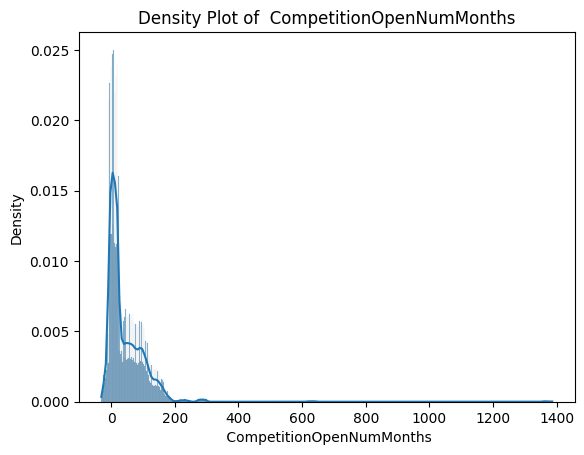

In [ ]:
#  density plot for CompetitionOpenNumMonths
sns.histplot(df['CompetitionOpenNumMonths'], kde=True, stat="density")
plt.xlabel(' CompetitionOpenNumMonths')
plt.ylabel('Density')
plt.title('Density Plot of  CompetitionOpenNumMonths')
plt.show()


It is visible that we have Negative values for CompetitionOpenNumMonths which is not acceptable.


If CompetitionOpenNumMonths is negative, it means we are looking at months before the competition started.

Negative months don’t make sense for this feature, because we want to know how long competition has existed, not how long until it starts.

Few of the reasons could be:

The store has sales data from before a competitor opened nearby.

The competition open date was entered incorrectly in the data.

There are missing or misaligned values in the CompetitionOpenSinceYear or CompetitionOpenSinceMonth columns.

In [ ]:
# dataset for negative CompetitionOpenNumMonths
df[df['CompetitionOpenNumMonths'] < 0].loc[:, ['CompetitionOpenNumMonths','CompetitionOpenSinceYear','WeekOfYear', 'Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks']]

CompetitionOpenNumMonths  CompetitionOpenSinceYear  WeekOfYear  Year  \
687                            -1                      2015          31  2015   
1019                           -1                      2015          31  2015   
1071                           -1                      2015          31  2015   
1802                           -1                      2015          31  2015   
2134                           -1                      2015          31  2015   
...                           ...                       ...         ...   ...   
1017193                        -8                      2013           1  2013   
1017204                       -17                      2014           1  2013   
1017206                        -8                      2013           1  2013   
1017207                        -8                      2013           1  2013   
1017208                        -8                      2013           1  2013   

         Promo2SinceWeek  Promo2SinceYear  Promo2NumWeeks  
687                   14             2011             225  
1019                   0                0          104811  
1071                   5             2010             286  
1802                  14             2011             225  
2134                   0                0          104811  
...                  ...              ...             ...  
1017193               14             2011              91  
1017204               31             2013             -30  
1017206                0                0          104677  
1017207                0                0          104677  
1017208               22             2012              31  

[170688 rows x 7 columns]

Some values are negative because in some observations, the competition has not opened when the sales was recorded.
It could be verifed as CompetitionOpenNumMonths=(Year−CompetitionOpenSinceYear)×12+(Month−CompetitionOpenSinceMonth) and for above it is all negative.
Therefore change all negative values to 0.

In [ ]:
# change negative values of CompetitionOpenNumMonths to 0
df['CompetitionOpenNumMonths'] = df['CompetitionOpenNumMonths'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
# dataset for negative CompetitionOpenNumMonths
df[df['CompetitionOpenNumMonths'] < 0].loc[:, ['CompetitionOpenNumMonths','CompetitionOpenSinceYear','WeekOfYear', 'Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks']]

Empty DataFrame
Columns: [CompetitionOpenNumMonths, CompetitionOpenSinceYear, WeekOfYear, Year, Promo2SinceWeek, Promo2SinceYear, Promo2NumWeeks]
Index: []

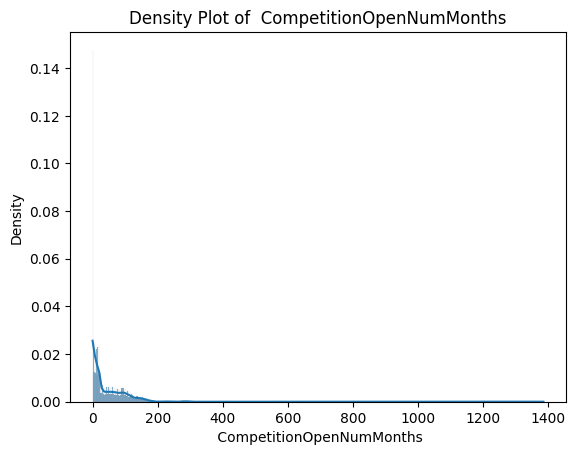

In [ ]:
#  density plot for CompetitionOpenNumMonths
sns.histplot(df['CompetitionOpenNumMonths'], kde=True, stat="density")
plt.xlabel(' CompetitionOpenNumMonths')
plt.ylabel('Density')
plt.title('Density Plot of  CompetitionOpenNumMonths')
plt.show()

# **check Promo2NumWeeks **

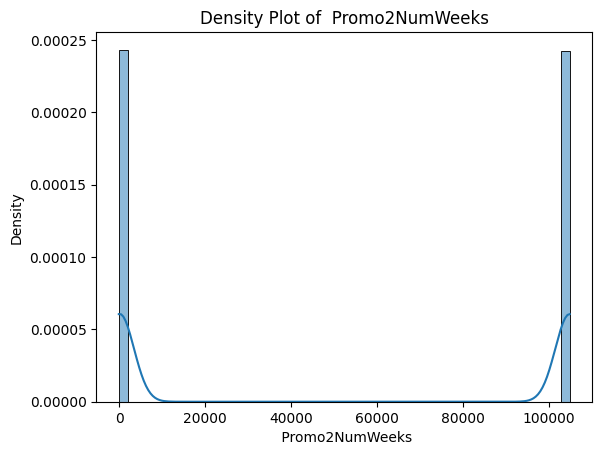

In [ ]:
#  density plot for CompetitionOpenNumMonths
sns.histplot(df['Promo2NumWeeks'], kde=True, stat="density")
plt.xlabel(' Promo2NumWeeks')
plt.ylabel('Density')
plt.title('Density Plot of  Promo2NumWeeks')
plt.show()

large values of Promo2NumWeeks are not possible.

If a store does not participate in Promo2, the columns Promo2SinceYear and Promo2SinceWeek are often set to 0 (as a placeholder for "not applicable").

When you calculate the difference with these zeros, the formula becomes:

Promo2NumWeeks
=
(
Year
−
0
)
×
52
+
(
WeekOfYear
−
0
)
Promo2NumWeeks=(Year−0)×52+(WeekOfYear−0)
For recent years, this results in very large numbers (e.g., for 2015:
(
2015
−
0
)
×
52
(2015−0)×52), which is not meaningful.

In [ ]:
# dataset for very large Promo2NumWeeks values
df[df['Promo2NumWeeks'] > 100000].loc[:, ['WeekOfYear', 'Promo2','Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks']]

WeekOfYear  Promo2  Year  Promo2SinceWeek  Promo2SinceYear  \
0                31       0  2015                0                0   
3                31       0  2015                0                0   
4                31       0  2015                0                0   
5                31       0  2015                0                0   
6                31       0  2015                0                0   
...             ...     ...   ...              ...              ...   
1017201           1       0  2013                0                0   
1017203           1       0  2013                0                0   
1017205           1       0  2013                0                0   
1017206           1       0  2013                0                0   
1017207           1       0  2013                0                0   

         Promo2NumWeeks  
0                104811  
3                104811  
4                104811  
5                104811  
6                104811  
...                 ...  
1017201          104677  
1017203          104677  
1017205          104677  
1017206          104677  
1017207          104677  

[508031 rows x 6 columns]

Large values in Promo2NumWeeks do not mean the promotion has been running for thousands of weeks.

It actually means the store never participated in Promo2, and the calculation is using placeholder zeros, leading to these unrealistic results.

Very large values of Promo2NumWeeks was observed because Promo2SinceYear and Promo2SinceWeek is 0 where Promo2 is 0. Lets change all those values to 0.

In [ ]:
# change the value of Promo2NumWeeks to 0 where Promo2 is 0
df.loc[df['Promo2'] == 0, 'Promo2NumWeeks'] = 0

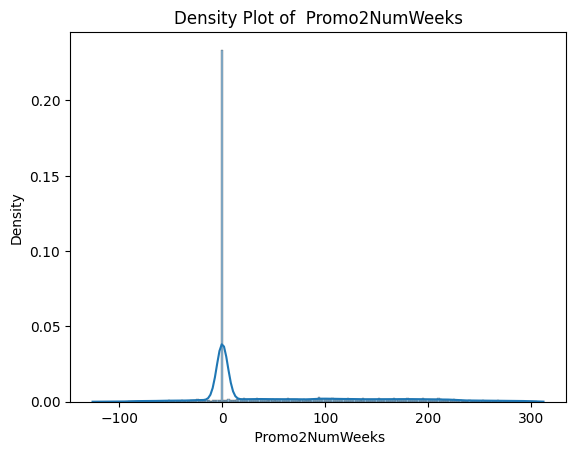

In [ ]:
#  density plot for CompetitionOpenNumMonths
sns.histplot(df['Promo2NumWeeks'], kde=True, stat="density")
plt.xlabel(' Promo2NumWeeks')
plt.ylabel('Density')
plt.title('Density Plot of  Promo2NumWeeks')
plt.show()

Negative values for Promo2NumWeeks are not acceptable.

If the sales date (represented by Year and WeekOfYear) is earlier than the date when Promo2 started (Promo2SinceYear and Promo2SinceWeek), the calculation gives a negative number

In [ ]:
# dataset for negative Promo2NumWeeks values
df[df['Promo2NumWeeks'] < 0].loc[:, ['WeekOfYear', 'Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks']]

WeekOfYear  Year  Promo2SinceWeek  Promo2SinceYear  Promo2NumWeeks
68442            22  2015               23             2015              -1
68643            22  2015               23             2015              -1
68886            22  2015               23             2015              -1
69557            22  2015               23             2015              -1
69758            22  2015               23             2015              -1
...             ...   ...              ...              ...             ...
1017195           1  2013               40             2014             -91
1017196           1  2013                5             2013              -4
1017198           1  2013                5             2013              -4
1017199           1  2013               31             2013             -30
1017204           1  2013               31             2013             -30

[69970 rows x 5 columns]

Some values are negative because in some observations, the promo 2 has not started when the sales was recorded. Lets change all negative values to 0.

In [ ]:
# change negative values of Promo2NumWeeks to 0
df['Promo2NumWeeks'] = df['Promo2NumWeeks'].apply(lambda x: 0 if x < 0 else x)

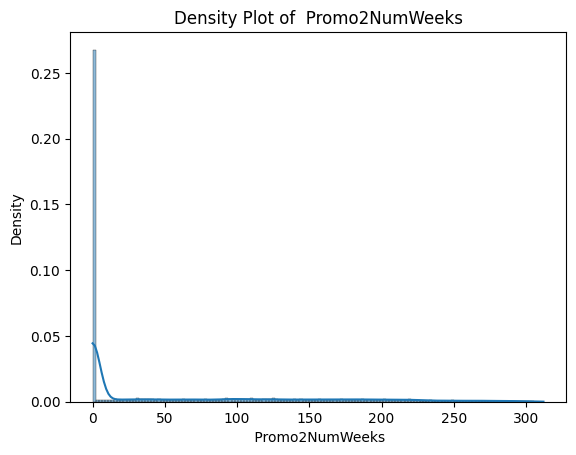

In [ ]:
#  density plot for CompetitionOpenNumMonths
sns.histplot(df['Promo2NumWeeks'], kde=True, stat="density")
plt.xlabel(' Promo2NumWeeks')
plt.ylabel('Density')
plt.title('Density Plot of  Promo2NumWeeks')
plt.show()

Chcking if there are any rows/columns with negative values


In [ ]:
numeric_df = df.select_dtypes(include=[np.number])

any_negative = (numeric_df < 0).any().any()
columns_with_neg = numeric_df.columns[(numeric_df < 0).any()].tolist()

rows_with_neg = numeric_df.index[(numeric_df < 0).any(axis=1)].tolist()

print("Any negative values in DataFrame?:", any_negative)
print("Columns with negative values:", columns_with_neg)
print("Rows with negative values:", rows_with_neg)


Any negative values in DataFrame?: False
Columns with negative values: []
Rows with negative values: []


In [ ]:
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             0   
1      2          5 2015-07-31   6064        625     1      1             0   
2      3          5 2015-07-31   8314        821     1      1             0   
3      4          5 2015-07-31  13995       1498     1      1             0   
4      5          5 2015-07-31   4822        559     1      1             0   

   SchoolHoliday StoreType  ... CompetitionOpenSinceYear  Promo2  \
0              1         c  ...                     2008       0   
1              1         a  ...                     2007       1   
2              1         a  ...                     2006       1   
3              1         c  ...                     2009       0   
4              1         a  ...                     2015       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  WeekOfYear  Month  Year  \
0                0                0                0          31      7  2015   
1               13             2010  Jan,Apr,Jul,Oct          31      7  2015   
2               14             2011  Jan,Apr,Jul,Oct          31      7  2015   
3                0                0                0          31      7  2015   
4                0                0                0          31      7  2015   

   CompetitionOpenNumMonths  Promo2NumWeeks  
0                        82               0  
1                        92             278  
2                       103             225  
3                        70               0  
4                         3               0  

[5 rows x 23 columns]

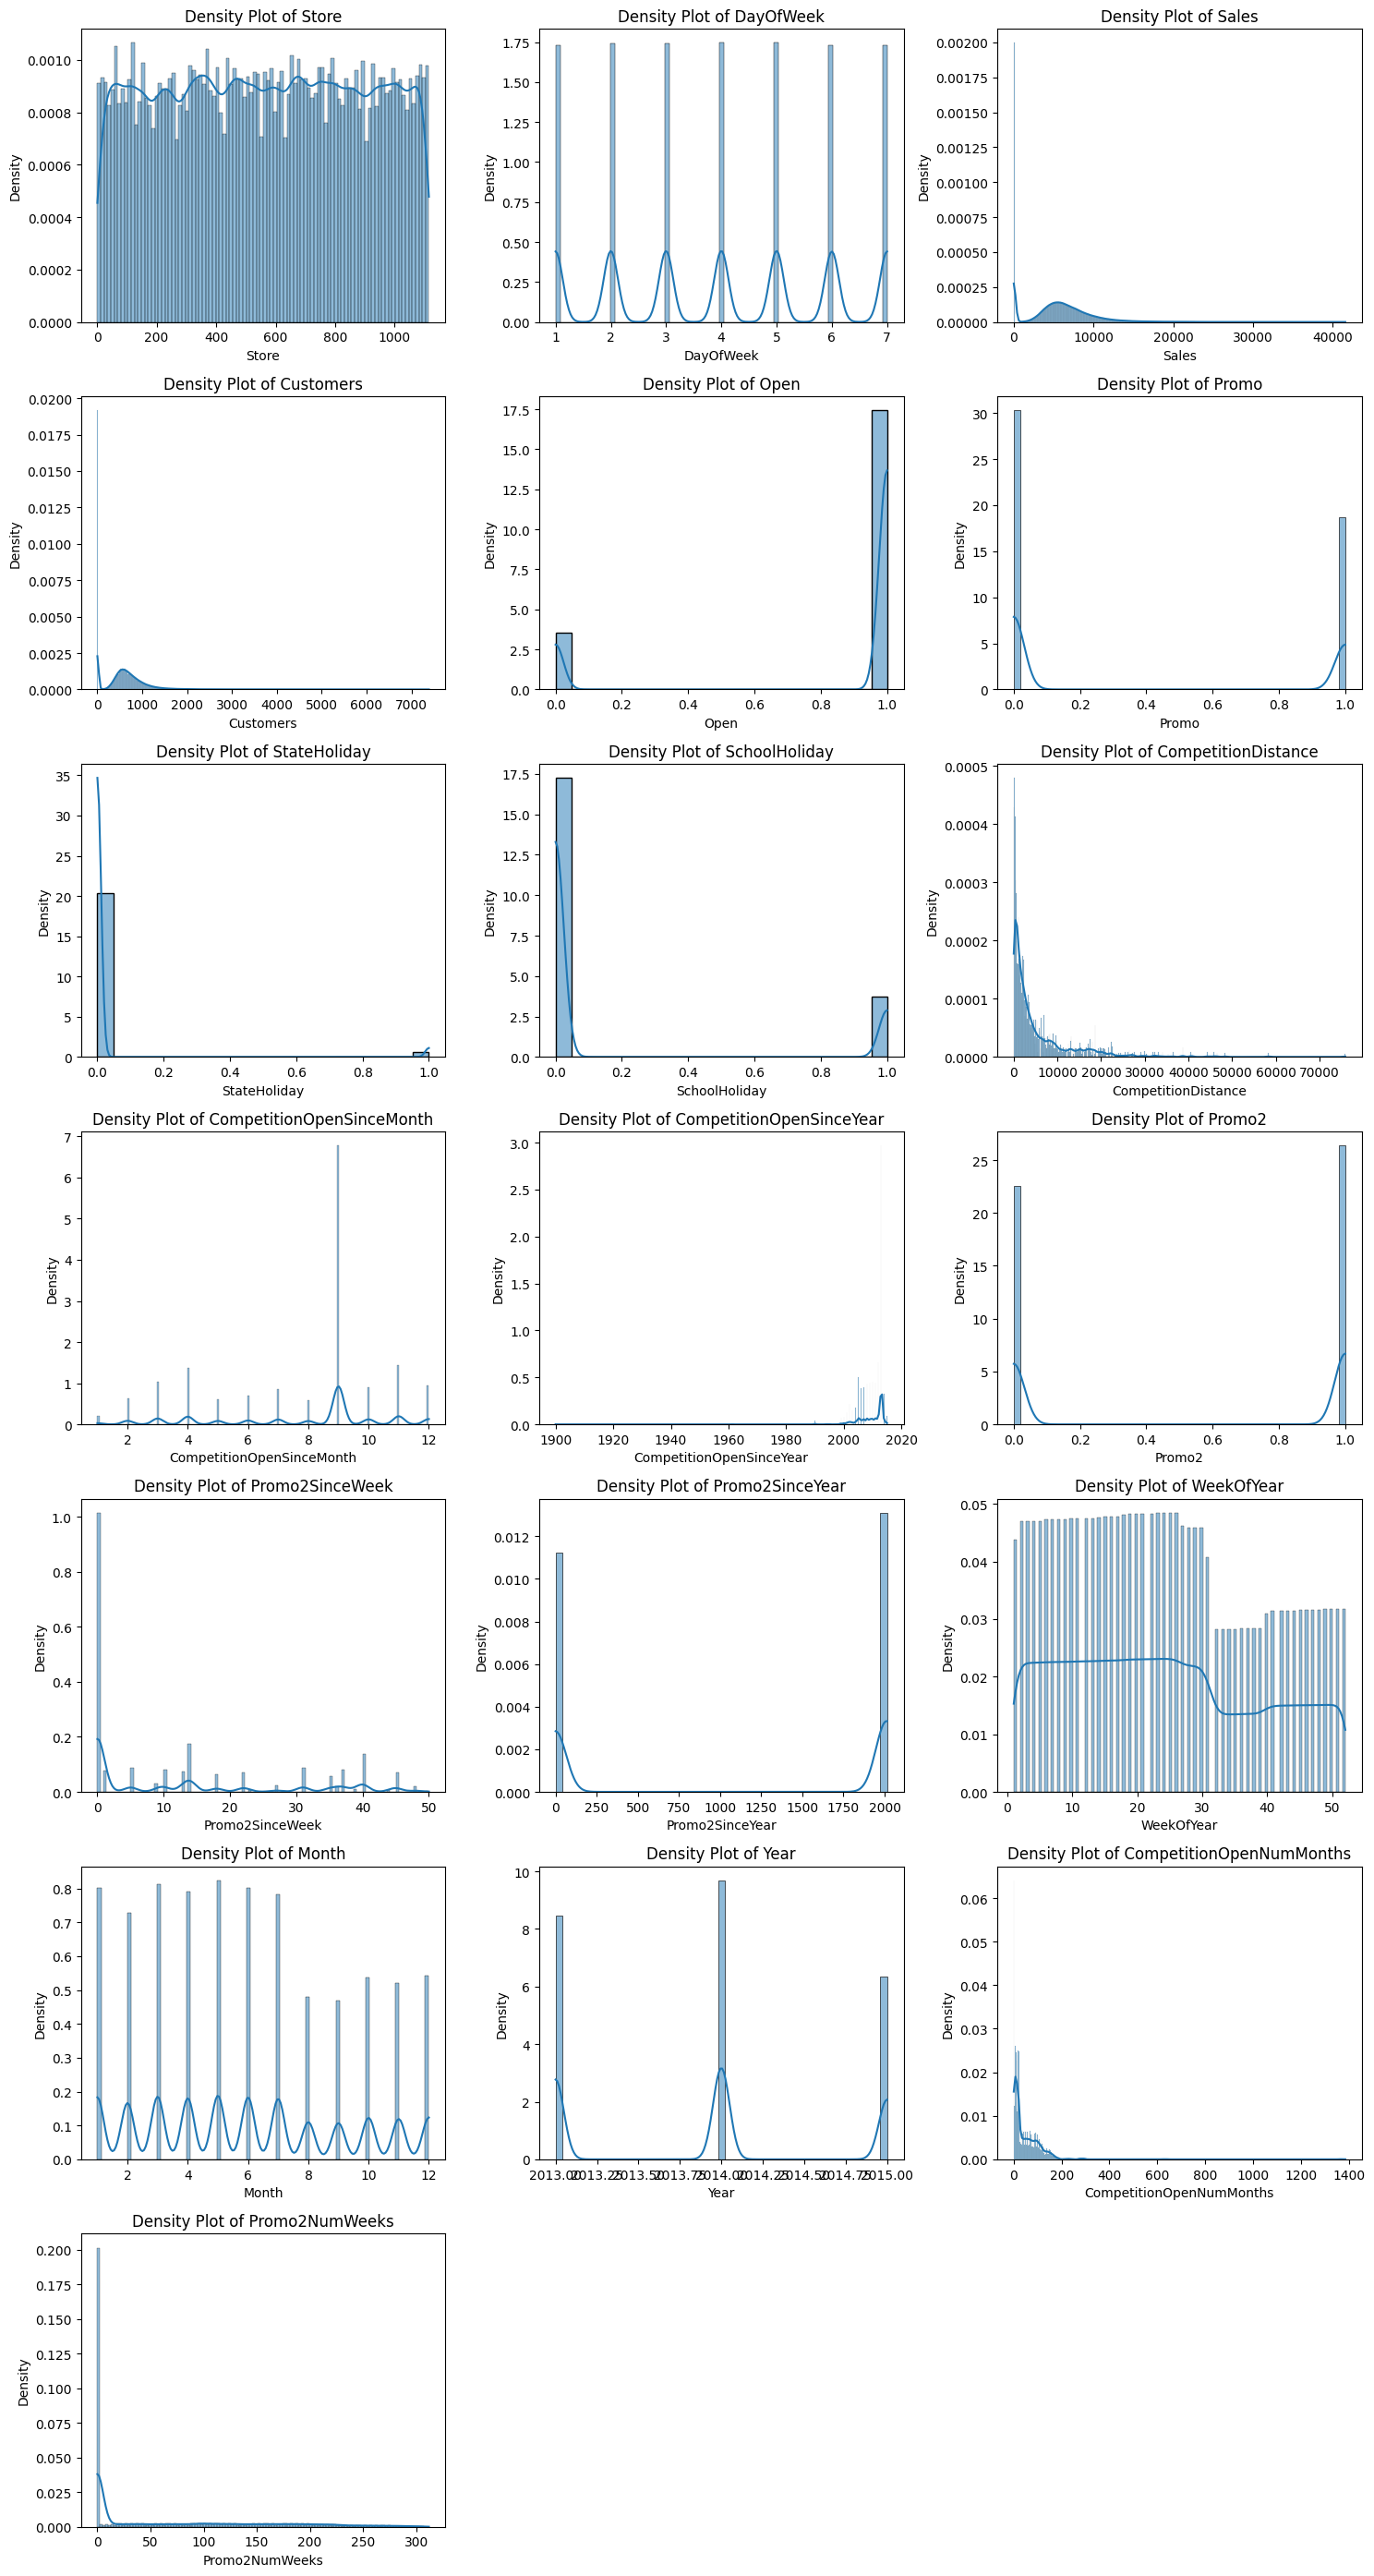

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def density_plot_of_all_features(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3  # Number of plots per row
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, stat='density')
        plt.title(f'Density Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

filtered_df = df[(df['CompetitionOpenNumMonths'] != 0) | (df['Promo2NumWeeks'] != 0)]

density_plot_of_all_features(filtered_df)


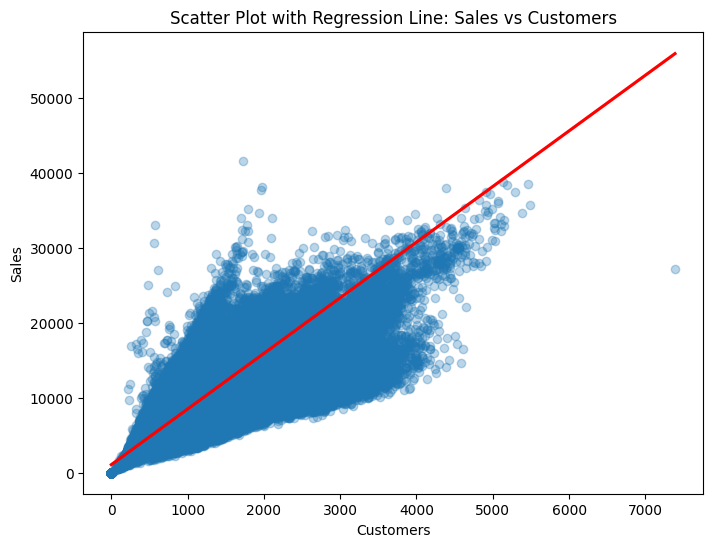

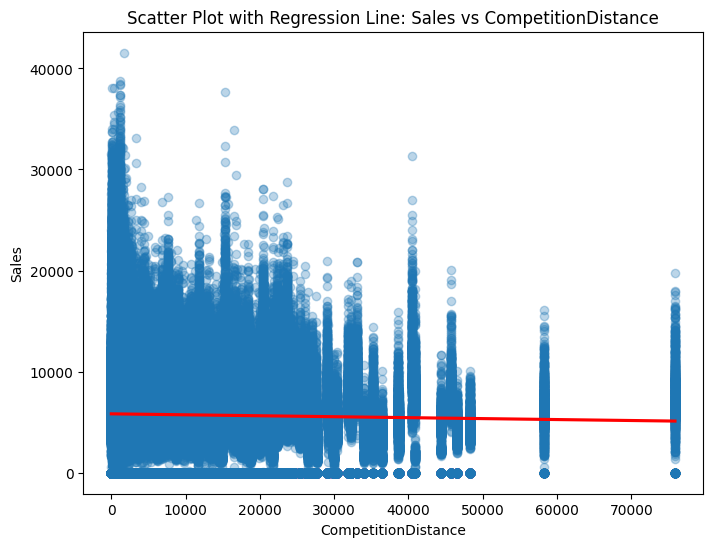

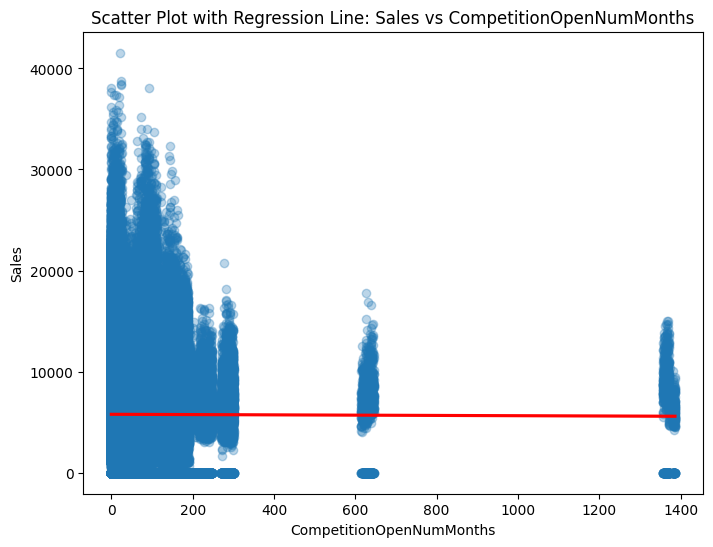

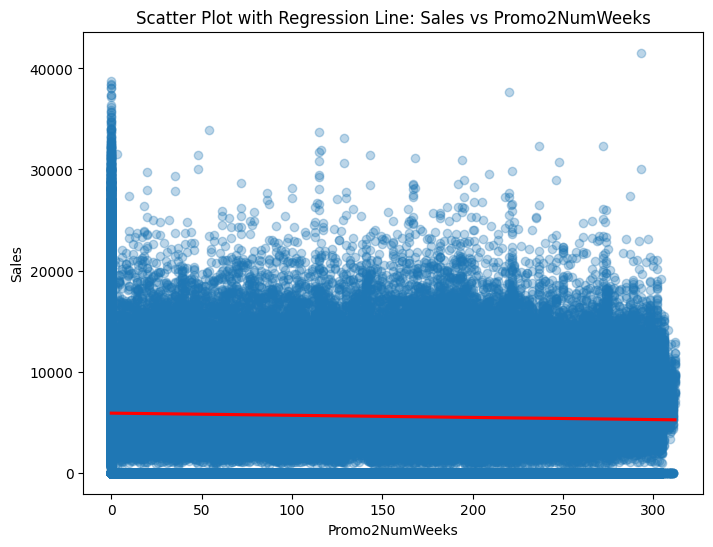

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# numerical features to plot against Sales
numerical_features = ['Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

def scatter_plot_with_regression_line(df, x_feature, y_feature):
    plt.figure(figsize=(8, 6))
    sns.regplot(
        x=x_feature,
        y=y_feature,
        data=df,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'}
    )
    plt.title(f'Scatter Plot with Regression Line: {y_feature} vs {x_feature}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

# Generate scatter plots for each numerical feature
for feature in numerical_features:
    scatter_plot_with_regression_line(df, feature, 'Sales')


Relationship between sales and customers is almost linear. So we can safely say that as the number of customers increases, sales also increase.
Sales decreases with increase in competition distance, competition open number of months and promo 2 number of weeks but they have very low correlation with competition distance.

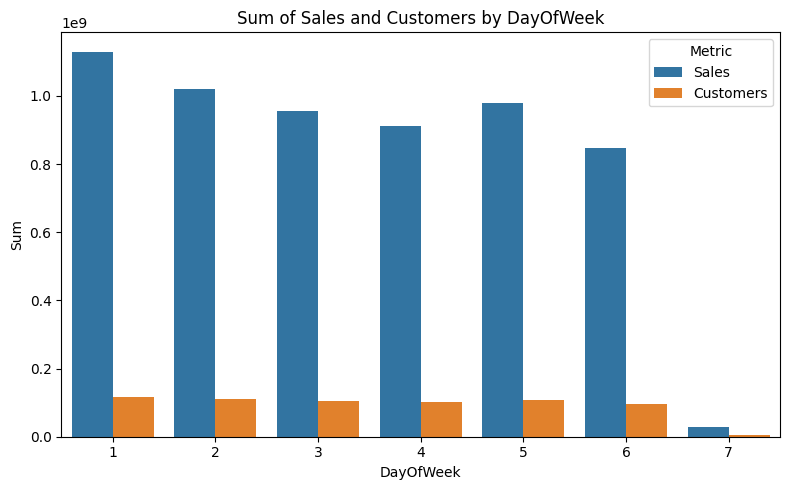

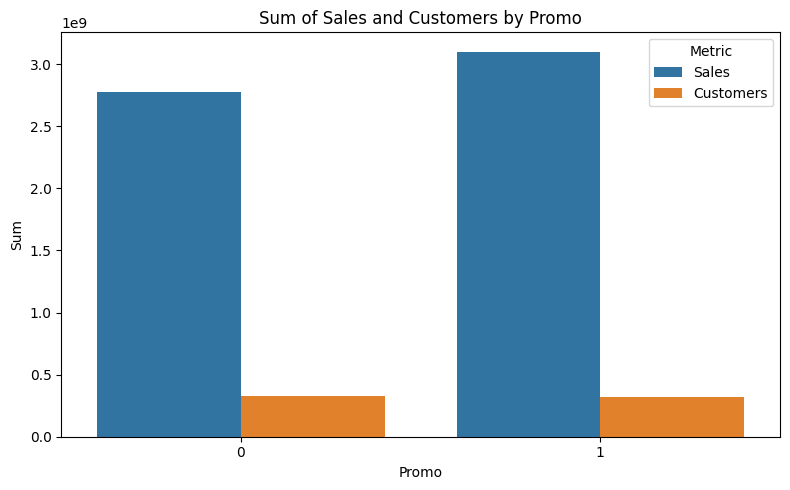

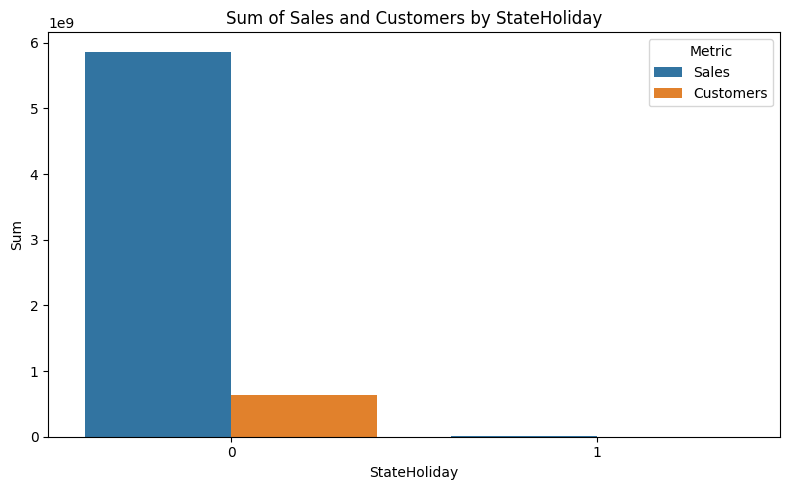

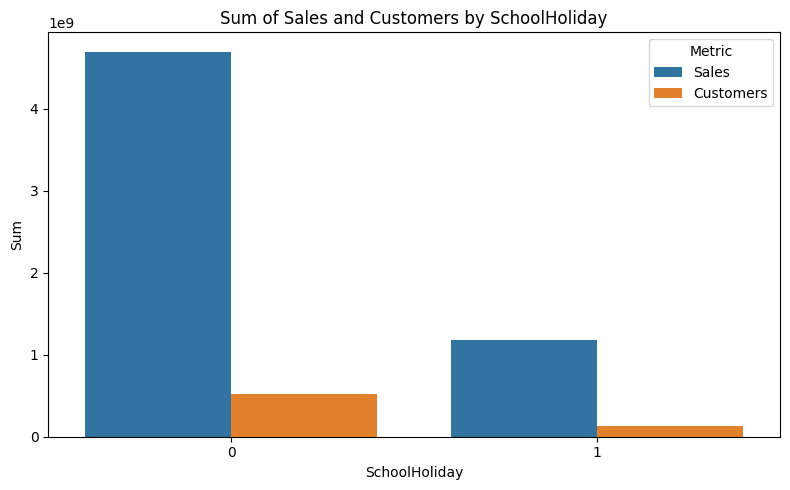

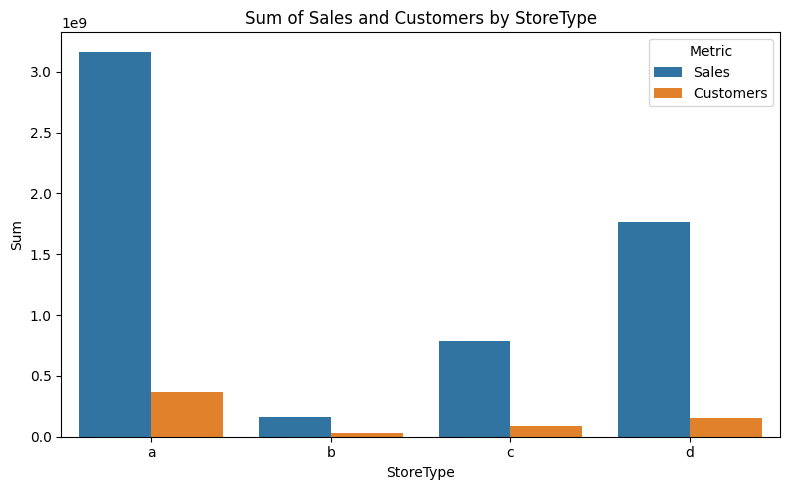

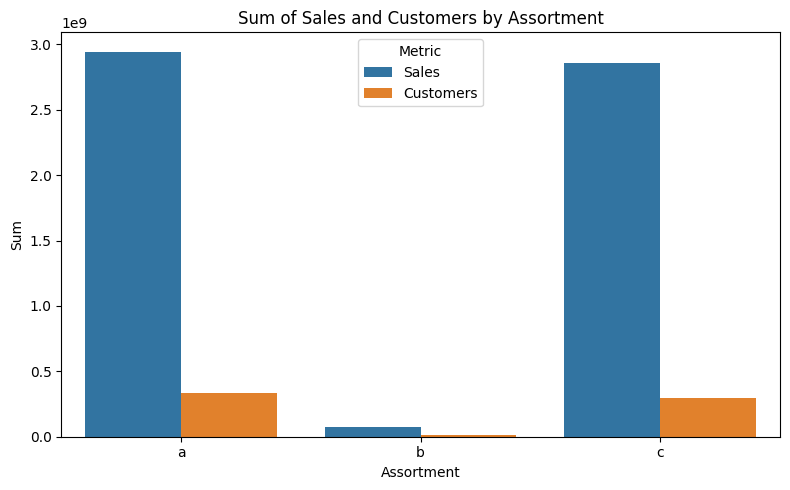

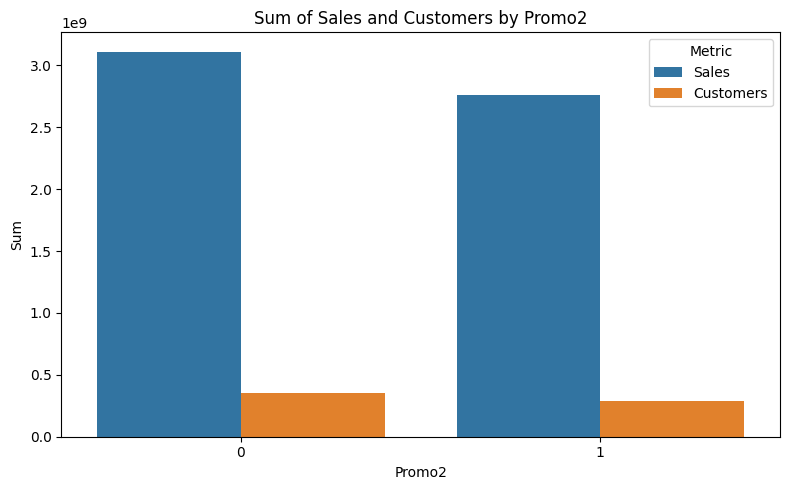

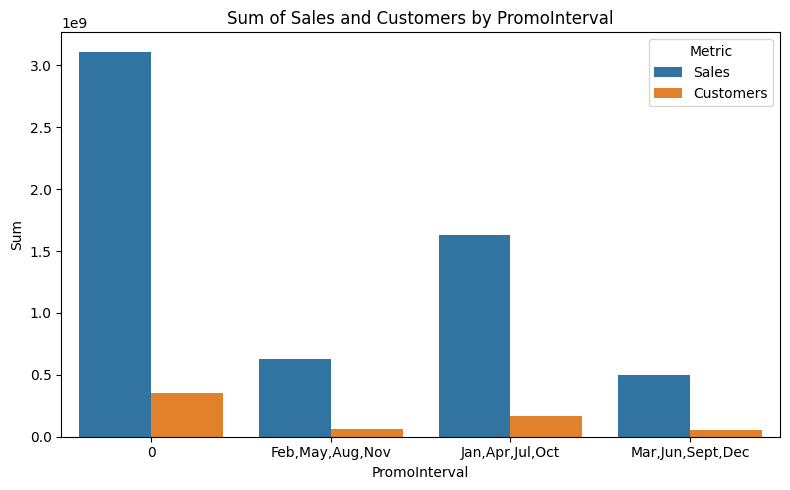

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical variables to consider
categorical_variables = [
    'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'Promo2', 'PromoInterval'
]

def plot_bar_graph_with_two_features(df, category_col, value_cols):
    """
    Plots grouped bar plots for the sum of two features by a categorical variable.
    """
    # Group by the categorical column and sum the value columns
    grouped = df.groupby(category_col)[value_cols].sum().reset_index()

    # Melt the DataFrame for easier plotting with seaborn
    melted = grouped.melt(id_vars=category_col, value_vars=value_cols,
                          var_name='Metric', value_name='Total')

    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=melted,
        x=category_col,
        y='Total',
        hue='Metric'
    )
    plt.title(f'Sum of Sales and Customers by {category_col}')
    plt.ylabel('Sum')
    plt.xlabel(category_col)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

# Generate bar plots for each categorical variable
for feature in categorical_variables:
    plot_bar_graph_with_two_features(df, feature, ['Sales', 'Customers'])


The following observations were made from the above graphs:

Highest sales are recorded on Mondays and lowest sales are recorded on Sundays. This may be because most of the shops are closed on Sundays and this leads to higher demand on the next day, which is Monday.
Presence of promos increases sales.
Shops are closed on all state holidays but sometimes some shops are opened during school holidays, which may be Saturdays.
Sales are higher on school holidays than other days.
Store type a records the most amount of sales mostly because the majority of the shops are type a.
Sales of assortment b is very rare.
Participants of promo 2 has less sales might be because it is seasonal and doesn't have any effect on sales.
Promo interval Jan, Apr, Jul, Oct brings in more sales.

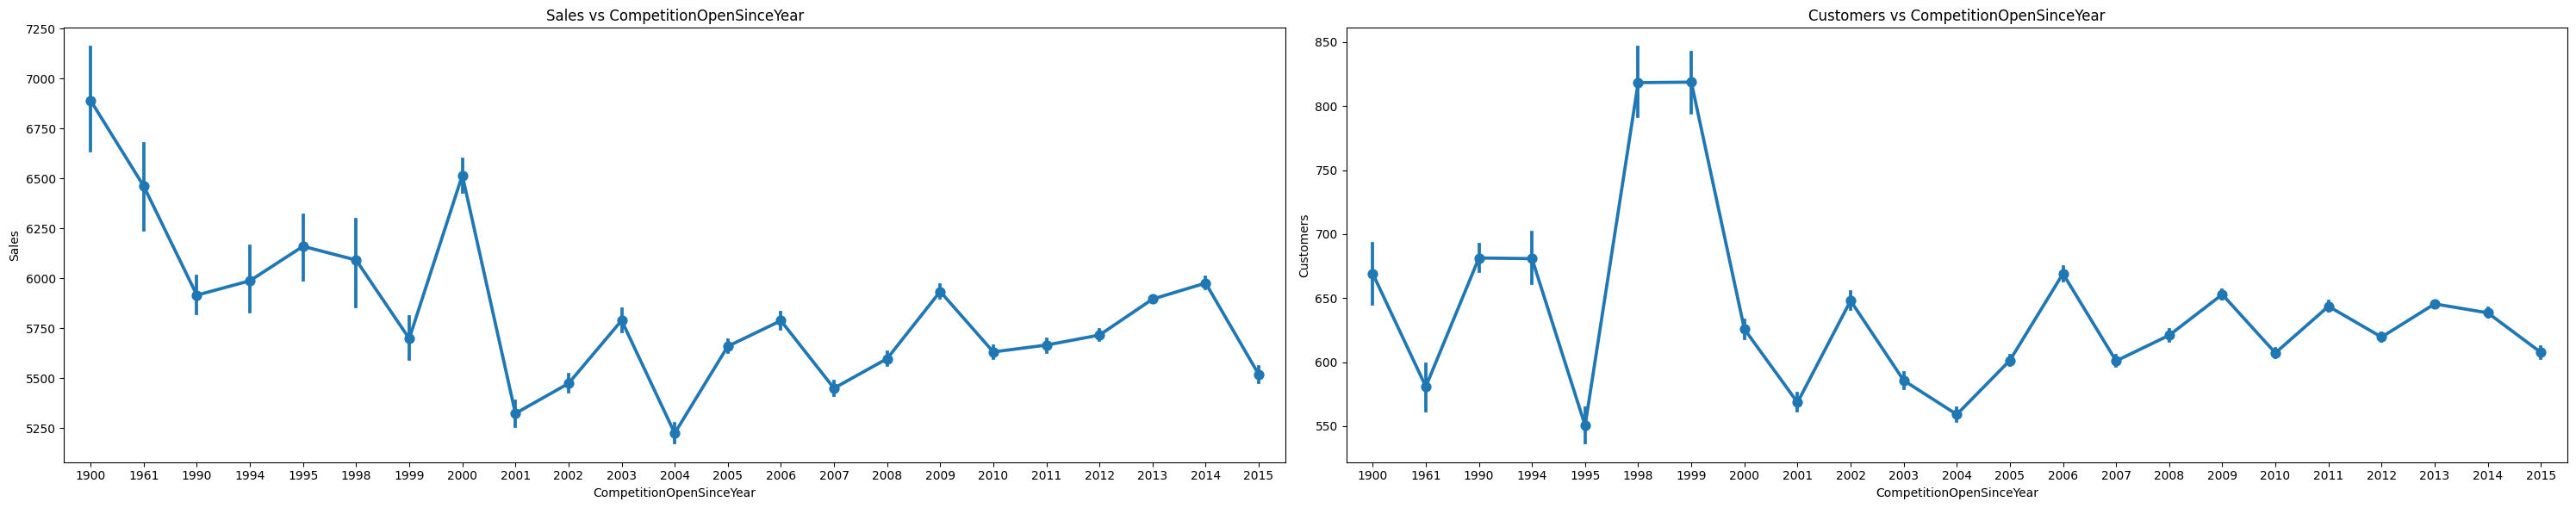

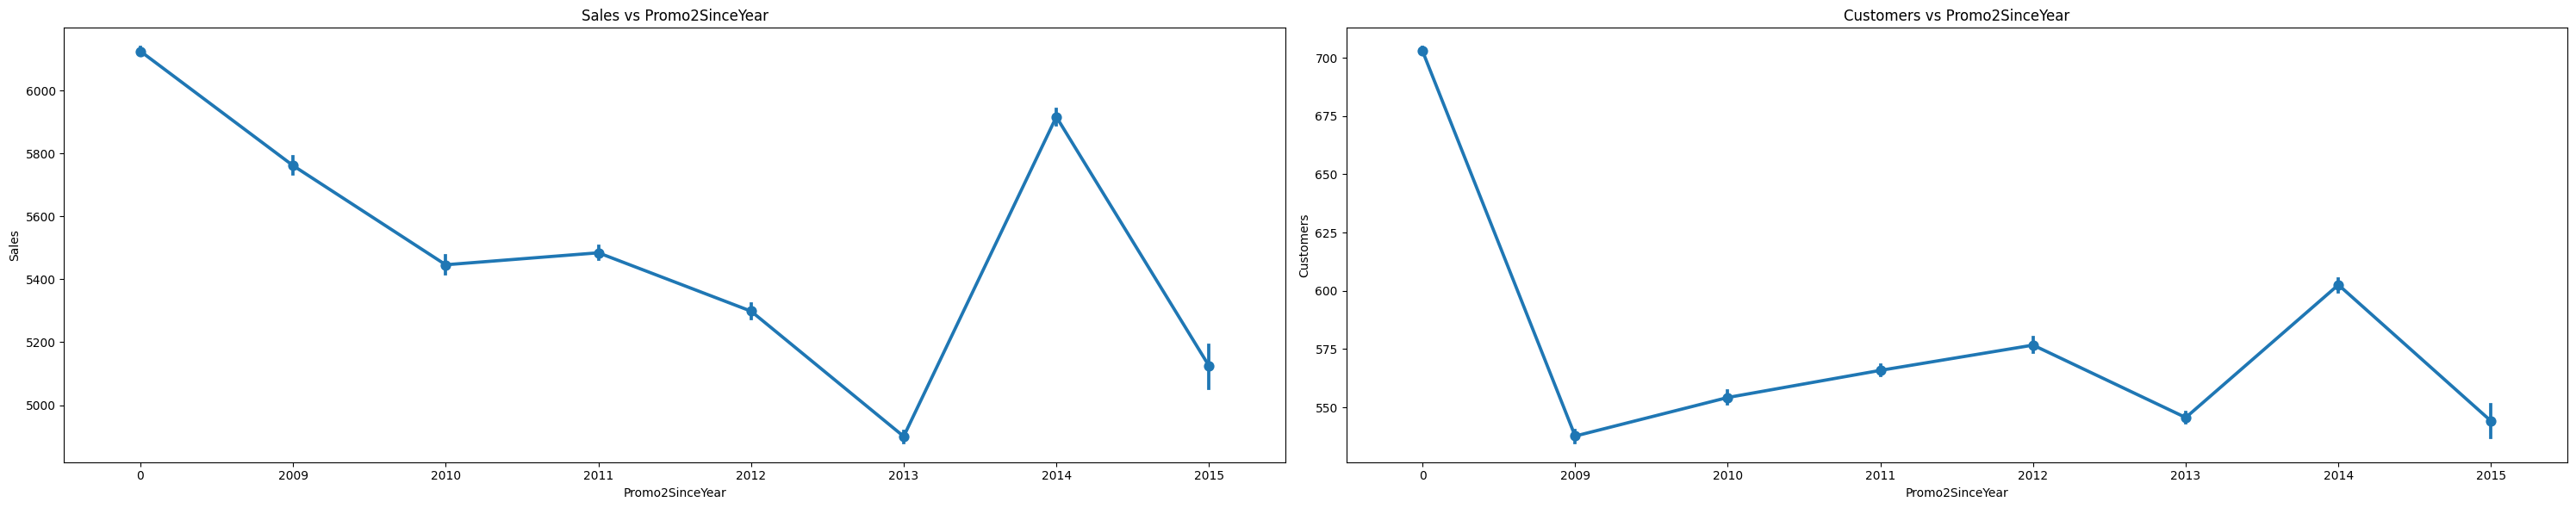

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in ('CompetitionOpenSinceYear', 'Promo2SinceYear'):
    fig, axes = plt.subplots(1, 2, figsize=(30, 6))

    # Plot point plot for Sales
    sns.pointplot(ax=axes[0], x=feature, y='Sales', data=df)
    axes[0].set_title(f'Sales vs {feature}')

    # Plot point plot for Customers
    sns.pointplot(ax=axes[1], x=feature, y='Customers', data=df)
    axes[1].set_title(f'Customers vs {feature}')

    plt.tight_layout()
    plt.show()


Sales peaked at 1900 when a few stores were present so there was only a little competition. As years passed sales started to decline due to the increase in competition. But number of customers has peaked during late 1990s. Sales due to promo 2 is generally decreasing over the years, only exception in 2014.

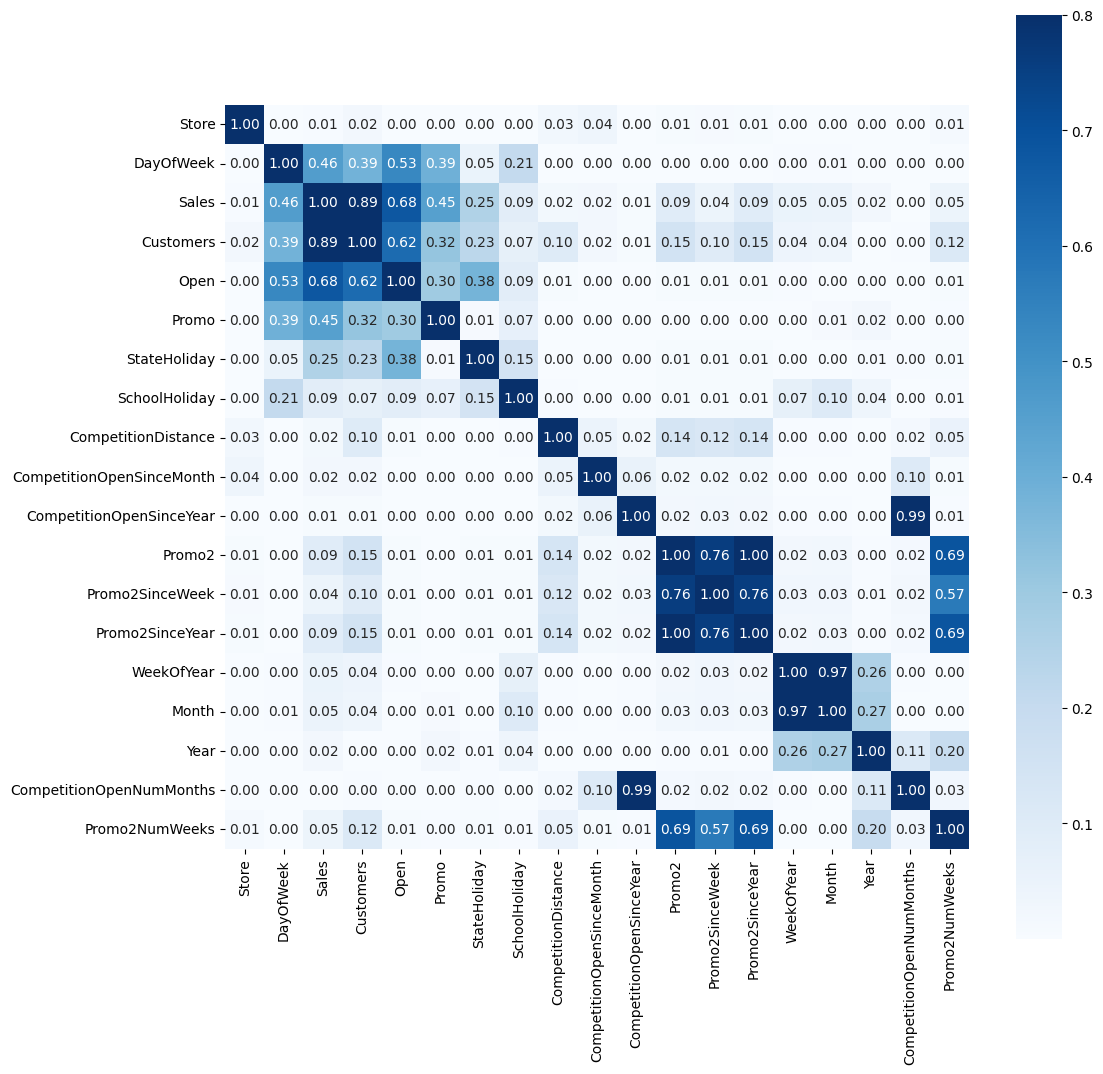

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])

corr_mat = numeric_df.corr().abs()

fig, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt='.2f',
    annot_kws={'size': 10},
    vmax=.8,
    square=True,
    cmap='Blues'
)
plt.show()

Customers and sales are also highly correlated because an increase in customers means that there must be an increase in sales too.

We can see that week of year and month are highly correlated, which is obvious since they represent points in the same timeframe but with different range.
Open is moderately correlated with sales and customers because customers, who drive sales, can access shops only when the shops are open.

Promo2 is correlated with promo2 since week and promo2 since year because promo2 is a binary feature and promo2 since week and promo2 since year have the value of 1 only when promo2 is 1.

Competition open number of months is highly correlated with competition open since year because it is derived from the latter.

Promo2 number of weeks is moderately correlated with Promo2, Promo2 since week and Promo2 since year as it is derived from these features.

# **Feature Selection**

Lets remove store since we need sales of all stores, not a particular one and also sales can be predicted through store type, assortment, etc.

In [ ]:
df.drop('Store', axis=1, inplace=True)

 remove date since there are already day of week and week of year features in the dataset.

In [ ]:
#  drop Date
# df.drop('Date', axis=1, inplace=True)

Lets remove competition open since month and competition open since year as the information provided by them can be obtained from competition open number of months.

In [ ]:
df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)

Lets remove promo 2, promo 2 since week and promo 2 since year as the information provided by them can be obtained from promo 2 number of weeks.

In [ ]:
df.drop(['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'], axis=1, inplace=True)

Lets remove month since we get the same information from week of the year.

In [ ]:
df.drop('Month', axis=1, inplace=True)

Lets remove year as we have already established in EDA that its not the year that influence the sales but the day of the week and the week of the year.

In [ ]:
df.drop('Year', axis=1, inplace=True)

In [ ]:
df.head()

DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0          5 2015-07-31   5263        555     1      1             0   
1          5 2015-07-31   6064        625     1      1             0   
2          5 2015-07-31   8314        821     1      1             0   
3          5 2015-07-31  13995       1498     1      1             0   
4          5 2015-07-31   4822        559     1      1             0   

   SchoolHoliday StoreType Assortment  CompetitionDistance    PromoInterval  \
0              1         c          a               1270.0                0   
1              1         a          a                570.0  Jan,Apr,Jul,Oct   
2              1         a          a              14130.0  Jan,Apr,Jul,Oct   
3              1         c          c                620.0                0   
4              1         a          a              29910.0                0   

   WeekOfYear  CompetitionOpenNumMonths  Promo2NumWeeks  
0          31                        82               0  
1          31                        92             278  
2          31                       103             225  
3          31                        70               0  
4          31                         3               0

# **Handling Multicollinearity**

Lets find out the VIF of all numerical features except 'Sales' in order to remove highly correlated features. Features having VIF greater than 5 should be eliminated.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# List of independent numerical features
numerical_independant_features = [
    'Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks'
]
X = df[numerical_independant_features].dropna()  # drop rows with missing values
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                    Feature       VIF
0                 Customers  1.500979
1       CompetitionDistance  1.256193
2  CompetitionOpenNumMonths  1.341305
3            Promo2NumWeeks  1.258342


# **Outliers**

Sales & **Customers**

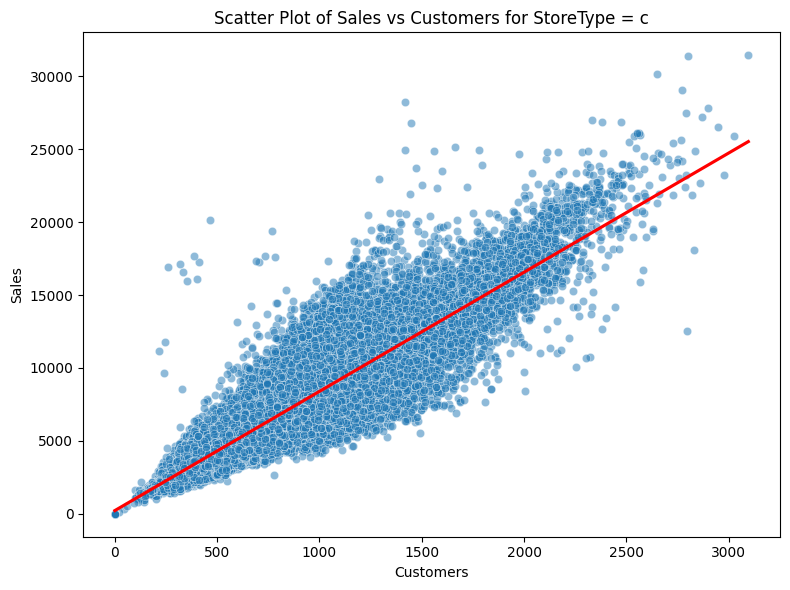

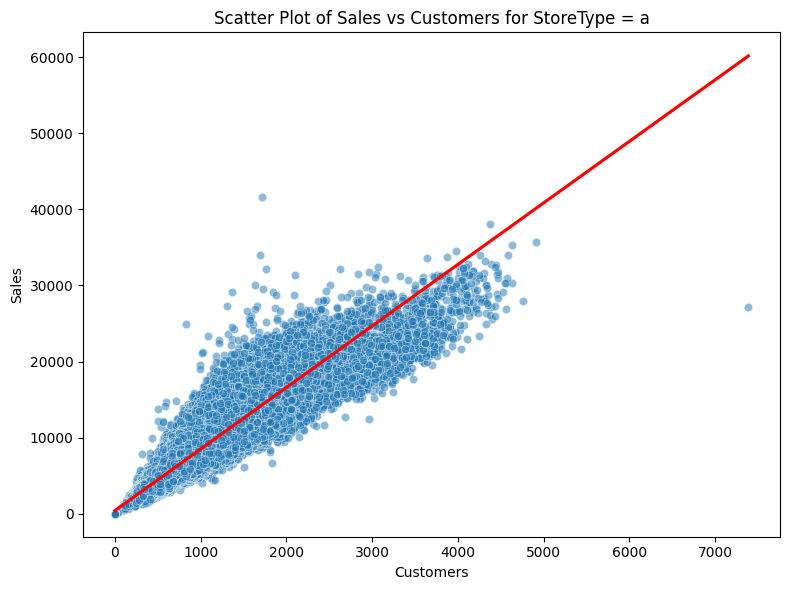

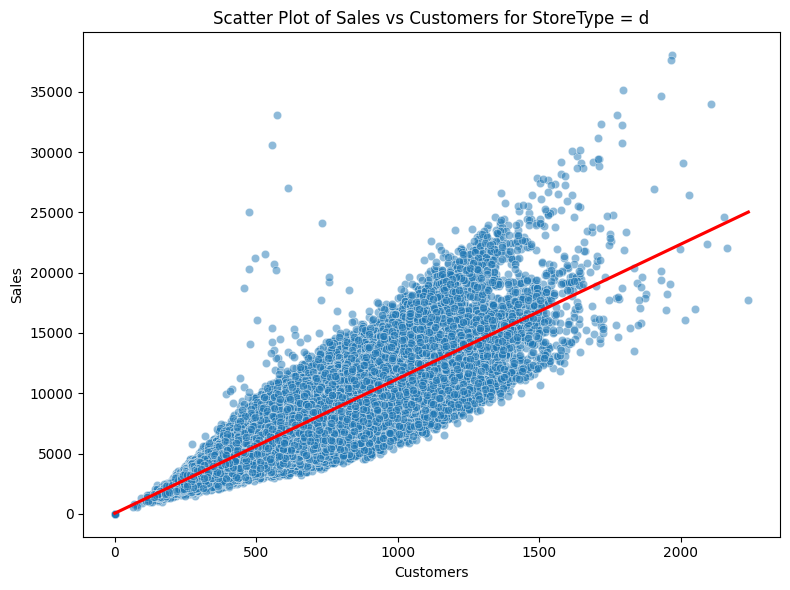

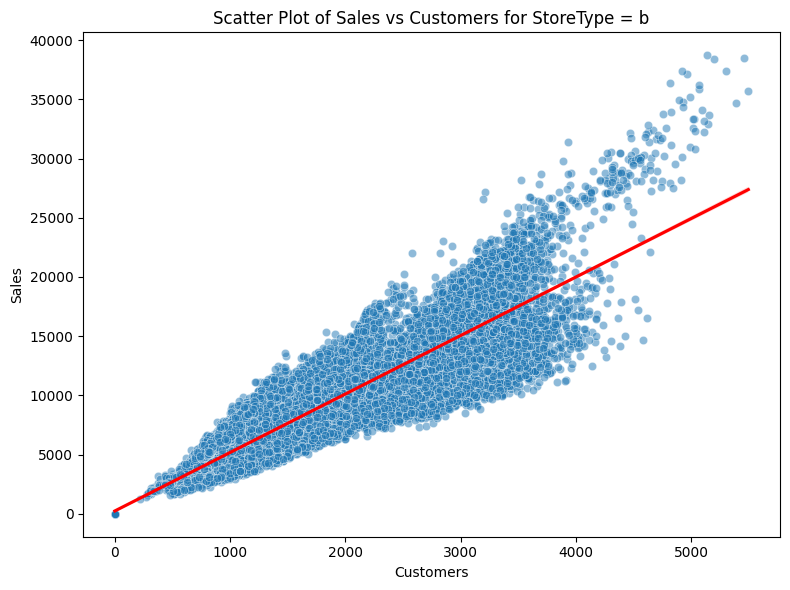

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot_bw_sales_customers_with_feature_unique_values(df, feature):
    unique_values = df[feature].unique()
    for value in unique_values:
        subset = df[df[feature] == value]
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='Customers', y='Sales', data=subset, alpha=0.5)
        sns.regplot(x='Customers', y='Sales', data=subset, scatter=False, color='red')
        plt.title(f'Scatter Plot of Sales vs Customers for {feature} = {value}')
        plt.xlabel('Customers')
        plt.ylabel('Sales')
        plt.tight_layout()
        plt.show()

# Usage example:
scatter_plot_bw_sales_customers_with_feature_unique_values(df, 'StoreType')


In [ ]:
# Remove outliers for StoreType 'a'
a_filter = df[
    (df['StoreType'] == 'a') & (
        ((df['Sales'] > 20000) & (df['Customers'] < 1000)) |
        (df['Sales'] > 40000) |
        (df['Customers'] > 7000)
    )
].index

# Remove outliers for StoreType 'c'
c_filter = df[
    (df['StoreType'] == 'c') & (
        ((df['Sales'] > 9000) & (df['Customers'] < 500)) |
        ((df['Sales'] < 15000) & (df['Customers'] > 2500)) |
        ((df['Sales'] > 25000) & (df['Customers'] < 2000)) |
        (df['Sales'] > 30000)
    )
].index

# Remove outliers for StoreType 'd'
d_filter = df[
    (df['StoreType'] == 'd') & (
        ((df['Sales'] > 17500) & (df['Customers'] < 875)) |
        (df['Sales'] > 31000) |
        (df['Customers'] > 2000)
    )
].index

# Drop the outliers from the DataFrame
df.drop(a_filter, inplace=True)
df.drop(c_filter, inplace=True)
df.drop(d_filter, inplace=True)


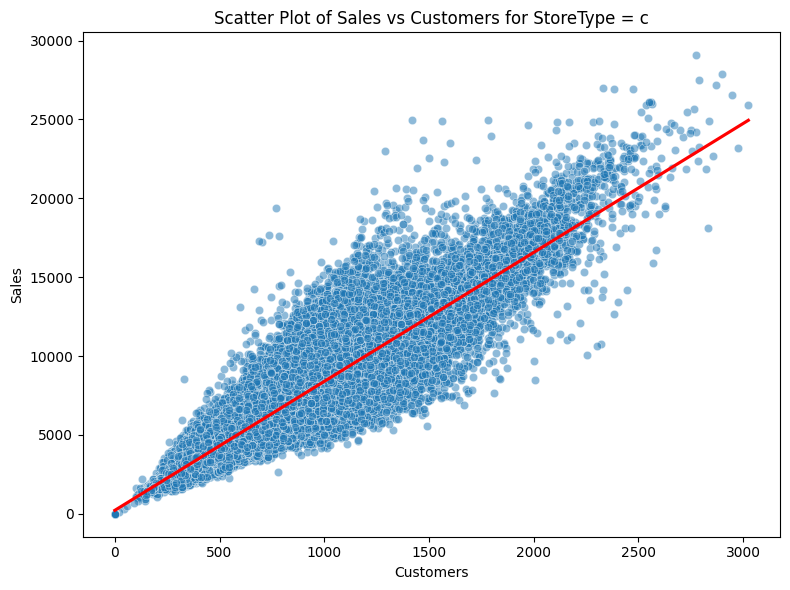

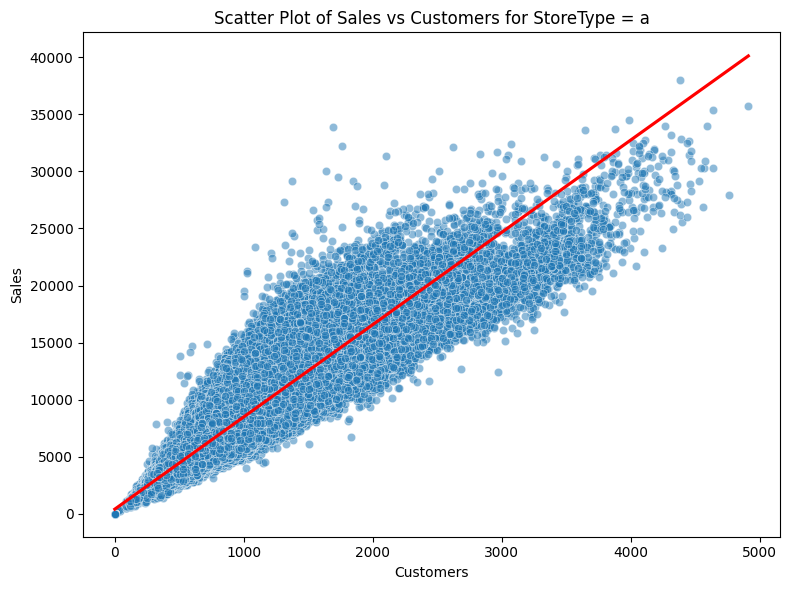

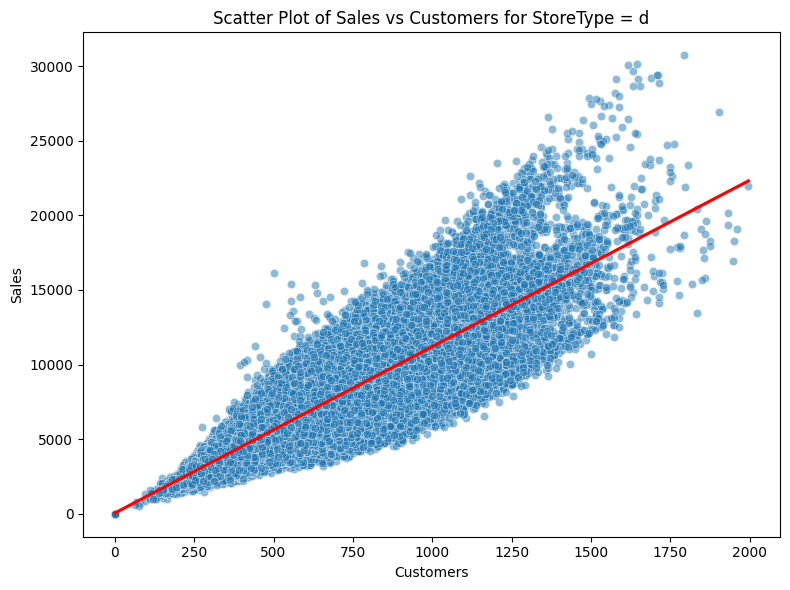

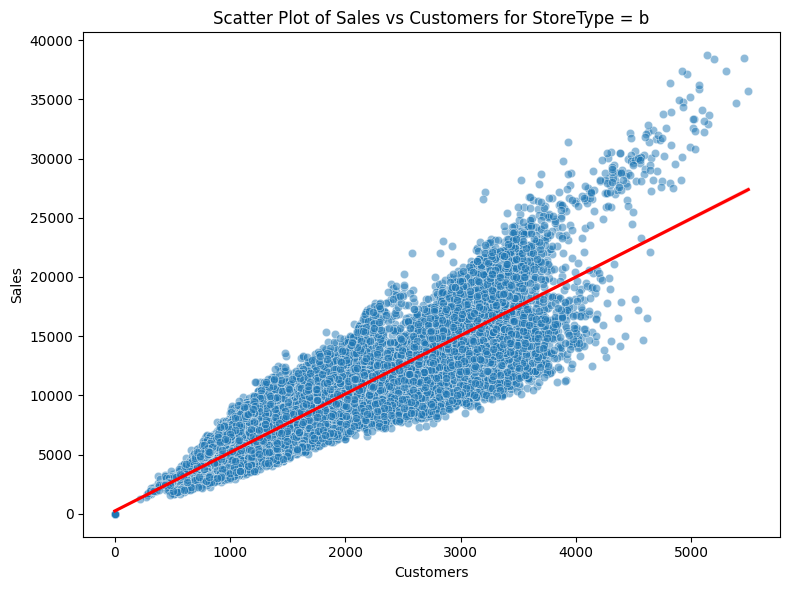

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatter_plot_bw_sales_customers_with_feature_unique_values(df, feature):
    unique_values = df[feature].unique()
    for value in unique_values:
        subset = df[df[feature] == value]
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='Customers', y='Sales', data=subset, alpha=0.5)
        sns.regplot(x='Customers', y='Sales', data=subset, scatter=False, color='red')
        plt.title(f'Scatter Plot of Sales vs Customers for {feature} = {value}')
        plt.xlabel('Customers')
        plt.ylabel('Sales')
        plt.tight_layout()
        plt.show()

# Usage example:
scatter_plot_bw_sales_customers_with_feature_unique_values(df, 'StoreType')


Unique Store Types: ['a', 'b', 'c', 'd']


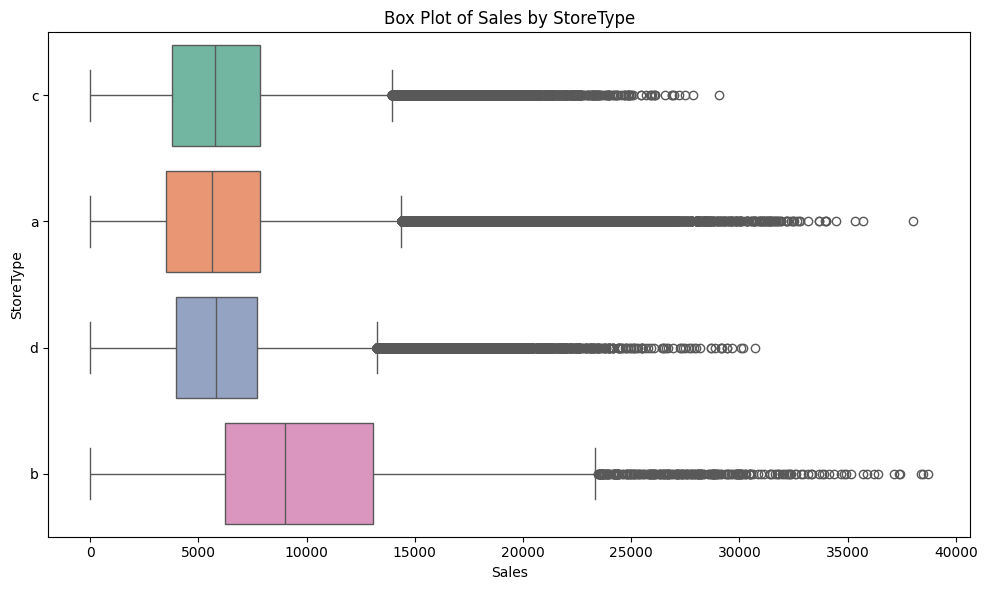

Outliers in sales in store type a: 14940 (2.71%)
Outliers in sales in store type b: 247 (1.56%)
Outliers in sales in store type c: 3077 (2.25%)
Outliers in sales in store type d: 5549 (1.77%)


In [ ]:
# Get sorted list of unique store types
store_types = sorted(df['StoreType'].unique().tolist())
print("Unique Store Types:", store_types)


def generate_horizontal_box_plot(data, value_col, category_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=data,
        x=value_col,
        y=category_col,
        orient='h',
        showfliers=True,  # Show outliers
        palette='Set2'
    )
    plt.title(f'Box Plot of {value_col} by {category_col}')
    plt.xlabel(value_col)
    plt.ylabel(category_col)
    plt.tight_layout()
    plt.show()

# Generate the box plot
generate_horizontal_box_plot(df, 'Sales', 'StoreType')

def get_outlier_count_and_percentage(data, col):
    # Calculate Q1 and Q3
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    count = outliers.shape[0]
    perc = round((count / data.shape[0]) * 100, 2) if data.shape[0] > 0 else 0
    return count, perc

# Print outlier count and percentage for each store type
for store_type in store_types:
    count, perc = get_outlier_count_and_percentage(df[df['StoreType'] == store_type], 'Sales')
    print(f"Outliers in sales in store type {store_type}: {count} ({perc}%)")


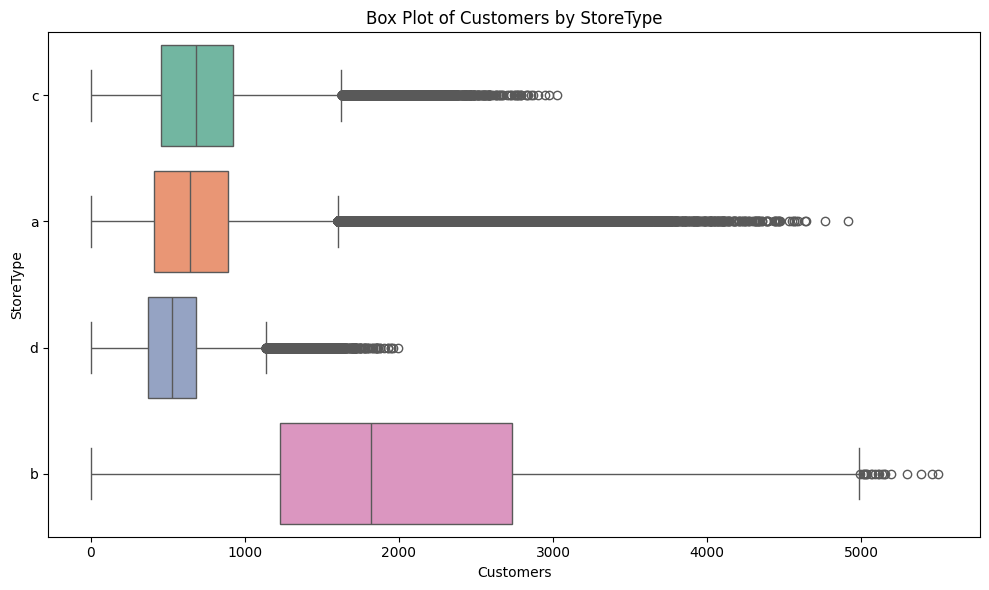

Outliers in customers in store type a: 17063 (3.09%)
Outliers in customers in store type b: 19 (0.12%)
Outliers in customers in store type c: 2884 (2.11%)
Outliers in customers in store type d: 4136 (1.32%)


In [ ]:
def generate_horizontal_box_plot(data, value_col, category_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=data,
        x=value_col,
        y=category_col,
        orient='h',
        showfliers=True,
        palette='Set2'
    )
    plt.title(f'Box Plot of {value_col} by {category_col}')
    plt.xlabel(value_col)
    plt.ylabel(category_col)
    plt.tight_layout()
    plt.show()

# Generate the box plot for Customers by StoreType
generate_horizontal_box_plot(df, 'Customers', 'StoreType')

def get_outlier_count_and_percentage(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    count = outliers.shape[0]
    perc = round((count / data.shape[0]) * 100, 2) if data.shape[0] > 0 else 0
    return count, perc

# Get unique store types
store_types = sorted(df['StoreType'].unique().tolist())

# Print outlier count and percentage for each store type
for store_type in store_types:
    count, perc = get_outlier_count_and_percentage(
        df[df['StoreType'] == store_type],
        'Customers'
    )
    print(f"Outliers in customers in store type {store_type}: {count} ({perc}%)")



From the above figures it is visible there are few outliers, hence if we eliminate them it could lead to overfitting,  hence we wont be eliminating them

**Assortment**

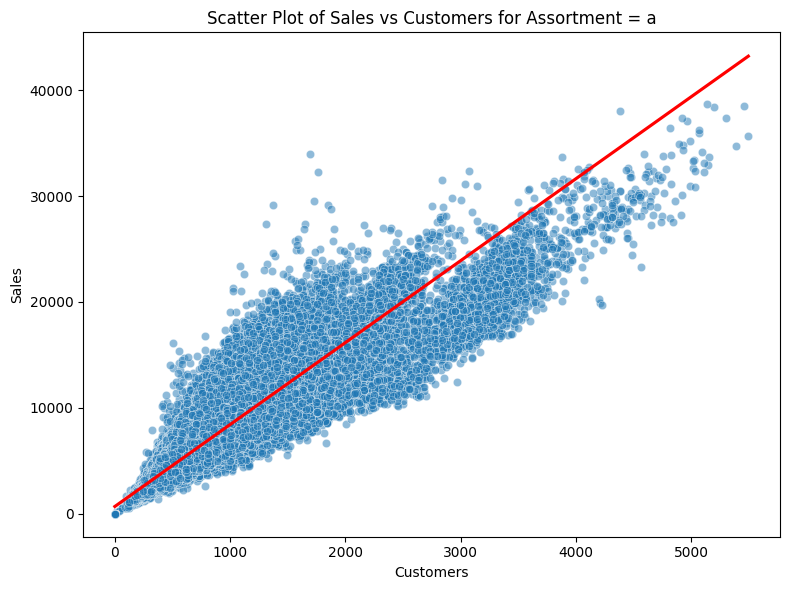

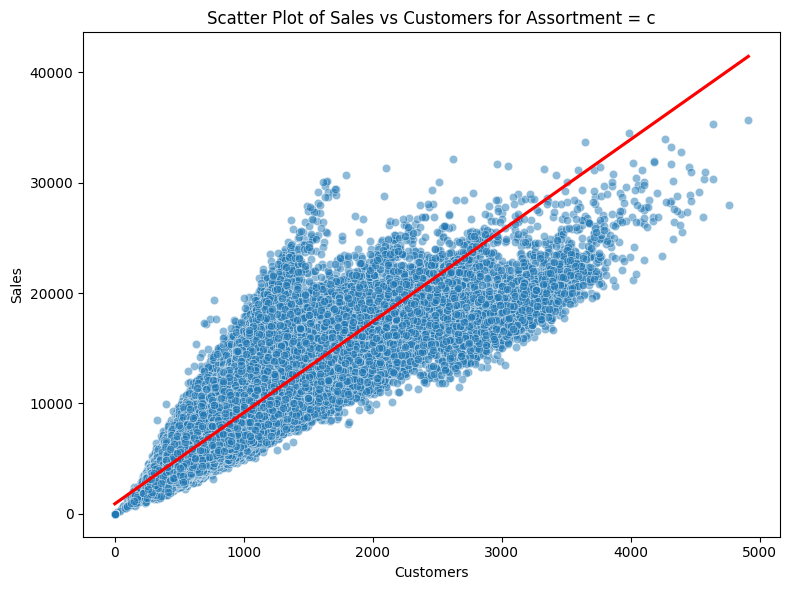

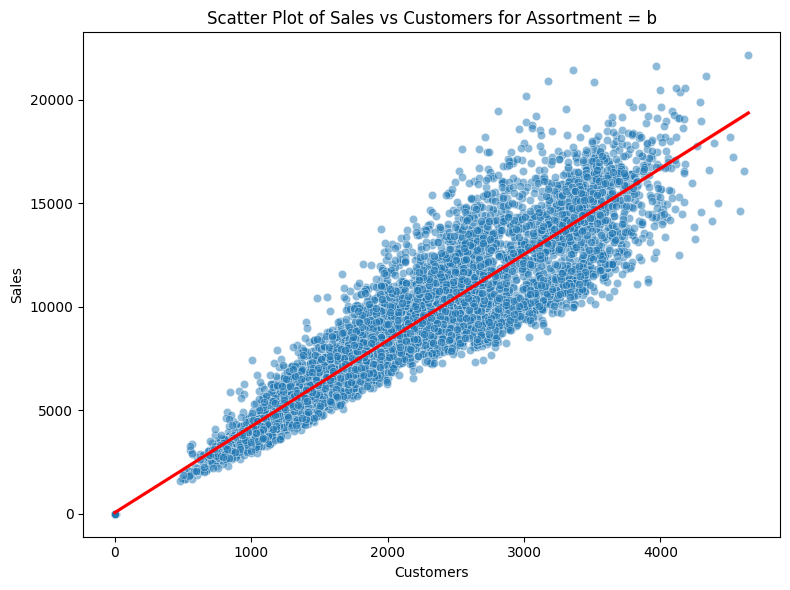

In [ ]:

def scatter_plot_bw_sales_customers_with_feature_unique_values(df, feature):
    unique_values = df[feature].unique()
    for value in unique_values:
        subset = df[df[feature] == value]
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='Customers', y='Sales', data=subset, alpha=0.5)
        sns.regplot(x='Customers', y='Sales', data=subset, scatter=False, color='red')
        plt.title(f'Scatter Plot of Sales vs Customers for {feature} = {value}')
        plt.xlabel('Customers')
        plt.ylabel('Sales')
        plt.tight_layout()
        plt.show()

scatter_plot_bw_sales_customers_with_feature_unique_values(df, 'Assortment')


In [ ]:
# remove outliers with respect to assortments
a_filter = df[(df['Assortment'] == 'a') & (((df['Sales'] > 20000) & (df['Customers'] < 1000)) |
                                                             ((df['Sales'] > 27500) & (df['Customers'] < 2000)) |
                                                             ((df['Sales'] > 31000) & (df['Customers'] < 3250)) |
                                                              (df['Sales'] > 35000))].index
df.drop(a_filter, inplace=True)

Unique Assortments: ['a', 'b', 'c']


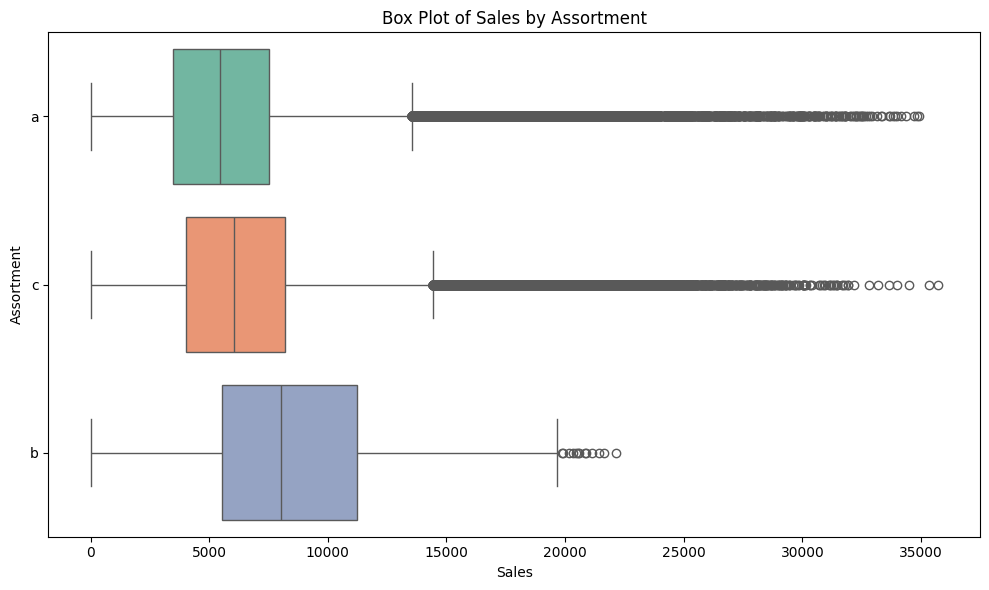

Outliers in sales in assortment a: 12384 (2.3%)
Outliers in sales in assortment b: 13 (0.16%)
Outliers in sales in assortment c: 13735 (2.91%)


In [ ]:
# Get sorted list of unique assortment types
assortments = sorted(df['Assortment'].unique().tolist())
print("Unique Assortments:", assortments)


def generate_horizontal_box_plot(data, value_col, category_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=data,
        x=value_col,
        y=category_col,
        orient='h',
        showfliers=True,
        palette='Set2'
    )
    plt.title(f'Box Plot of {value_col} by {category_col}')
    plt.xlabel(value_col)
    plt.ylabel(category_col)
    plt.tight_layout()
    plt.show()

# Generate the box plot for Sales by Assortment
generate_horizontal_box_plot(df, 'Sales', 'Assortment')


def get_outlier_count_and_percentage(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    count = outliers.shape[0]
    perc = round((count / data.shape[0]) * 100, 2) if data.shape[0] > 0 else 0
    return count, perc

# Print outlier count and percentage for each assortment type
for assortment in assortments:
    count, perc = get_outlier_count_and_percentage(
        df[df['Assortment'] == assortment],
        'Sales'
    )
    print(f"Outliers in sales in assortment {assortment}: {count} ({perc}%)")



Unique Assortments: ['a', 'b', 'c']


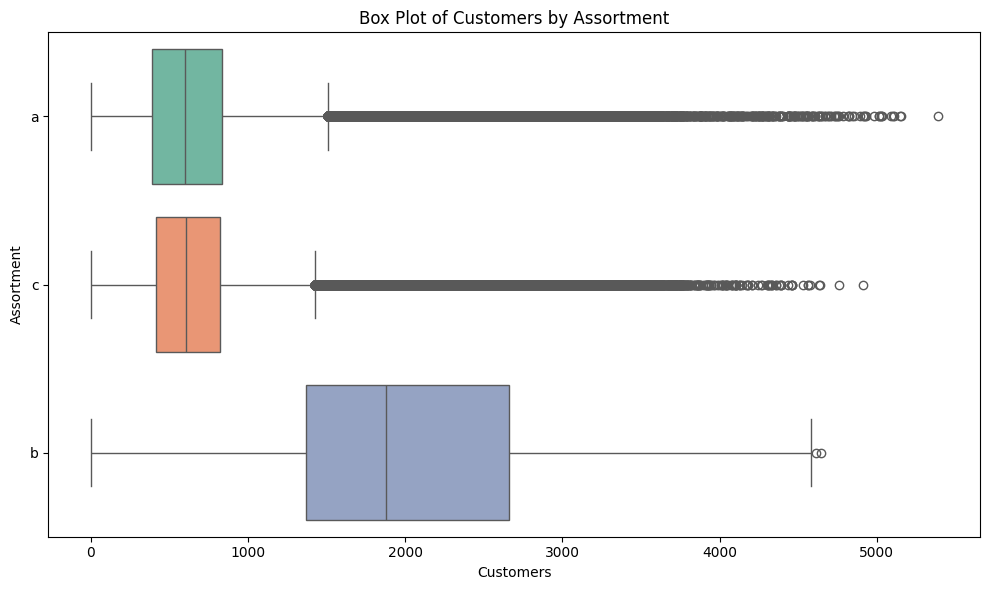

Outliers in customers in assortment a: 15624 (2.91%)
Outliers in customers in assortment b: 2 (0.02%)
Outliers in customers in assortment c: 17824 (3.78%)


In [ ]:
# Get sorted list of unique assortment types
assortments = sorted(df['Assortment'].unique().tolist())
print("Unique Assortments:", assortments)

def generate_horizontal_box_plot(data, value_col, category_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=data,
        x=value_col,
        y=category_col,
        orient='h',
        showfliers=True,
        palette='Set2'
    )
    plt.title(f'Box Plot of {value_col} by {category_col}')
    plt.xlabel(value_col)
    plt.ylabel(category_col)
    plt.tight_layout()
    plt.show()

# Generate the box plot for Customers by Assortment
generate_horizontal_box_plot(df, 'Customers', 'Assortment')

def get_outlier_count_and_percentage(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    count = outliers.shape[0]
    perc = round((count / data.shape[0]) * 100, 2) if data.shape[0] > 0 else 0
    return count, perc

# Print outlier count and percentage for each assortment type
for assortment in assortments:
    count, perc = get_outlier_count_and_percentage(
        df[df['Assortment'] == assortment],
        'Customers'
    )
    print(f"Outliers in customers in assortment {assortment}: {count} ({perc}%)")


From the above figures it is visible there are few outliers, hence if we eliminate them it could lead to overfitting, hence we wont be eliminating them

**Competition** **Distance**

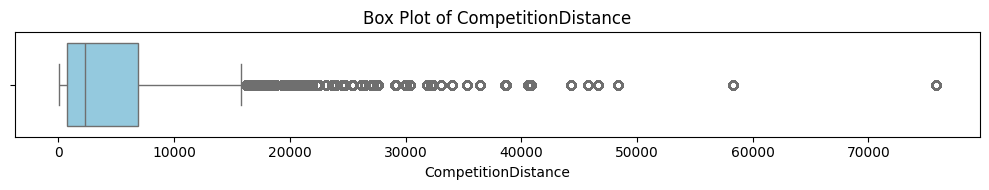

Outliers in competition distance : 99158 (9.75%)


In [ ]:
# Function for a simple horizontal box plot of a single column
def generate_horizontal_box_plot_single(data, value_col):
    plt.figure(figsize=(10, 2))
    sns.boxplot(
        x=data[value_col],
        orient='h',
        showfliers=True,
        color='skyblue'
    )
    plt.title(f'Box Plot of {value_col}')
    plt.xlabel(value_col)
    plt.tight_layout()
    plt.show()

def get_outlier_count_and_percentage(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    count = outliers.shape[0]
    perc = round((count / data.shape[0]) * 100, 2) if data.shape[0] > 0 else 0
    return count, perc

generate_horizontal_box_plot_single(df, 'CompetitionDistance')

count, perc = get_outlier_count_and_percentage(df, 'CompetitionDistance')
print(f"Outliers in competition distance : {count} ({perc}%)")


Almost 10% of data are outliers and removing them will cause the loss of useful information. What we can do is eliminate only a certain portion of outliers.


There are three options for the section of outliers that we can remove:

Competition distance > 55000

Competition distance > 44000

Competition distance > 37500

In [ ]:
# List of threshold values to check
limits = [55000, 44000, 37500]

# Loop through each limit and calculate count and percentage
for limit in limits:
    count = df[df['CompetitionDistance'] > limit].shape[0]
    perc = round(count / df.shape[0] * 100, 2)
    print(f"Count & percentage of data above {limit} : {count} ({perc}%)")


Count & percentage of data above 55000 : 1884 (0.19%)
Count & percentage of data above 44000 : 5652 (0.56%)
Count & percentage of data above 37500 : 9420 (0.93%)


Choose the 3rd option as it removes the most outliers

In [ ]:
df.drop(df[df['CompetitionDistance'] > 37500].index, inplace=True)

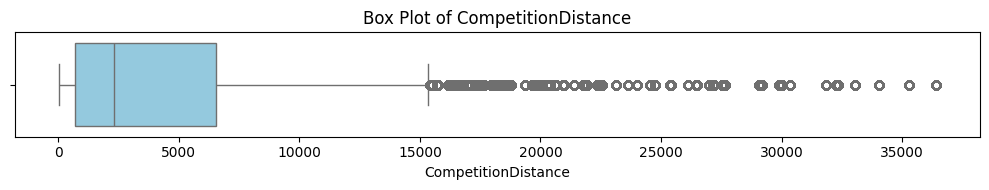

Outliers in competition distance : 95022 (9.43%)


In [ ]:
# Function for a simple horizontal box plot of a single column
def generate_horizontal_box_plot_single(data, value_col):
    plt.figure(figsize=(10, 2))
    sns.boxplot(
        x=data[value_col],
        orient='h',
        showfliers=True,
        color='skyblue'
    )
    plt.title(f'Box Plot of {value_col}')
    plt.xlabel(value_col)
    plt.tight_layout()
    plt.show()

def get_outlier_count_and_percentage(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    count = outliers.shape[0]
    perc = round((count / data.shape[0]) * 100, 2) if data.shape[0] > 0 else 0
    return count, perc

generate_horizontal_box_plot_single(df, 'CompetitionDistance')

count, perc = get_outlier_count_and_percentage(df, 'CompetitionDistance')
print(f"Outliers in competition distance : {count} ({perc}%)")


### **Log Transformation and Square Root Transformation**


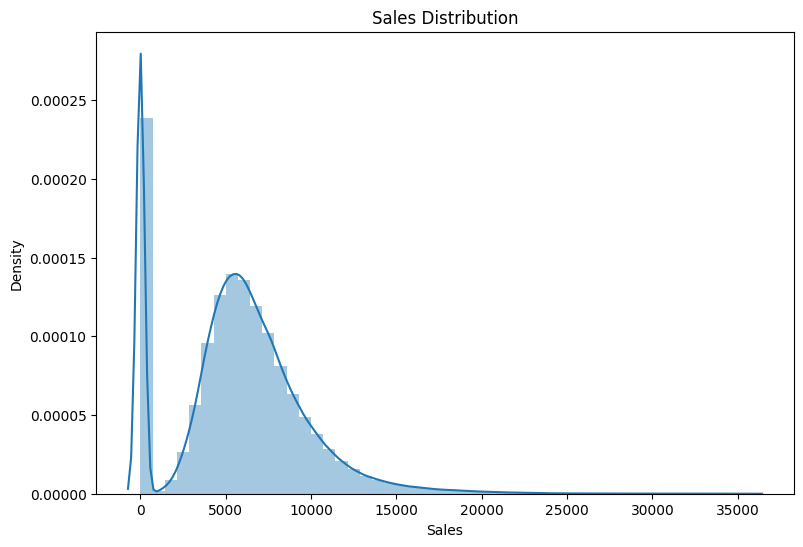

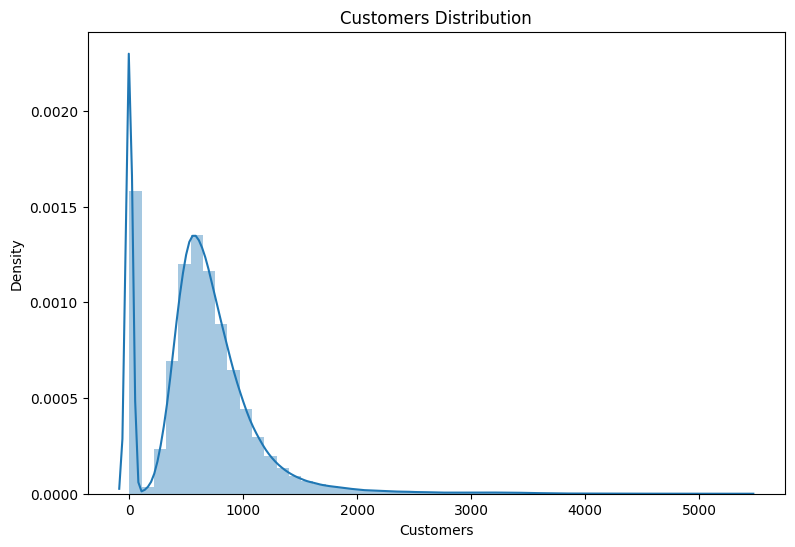

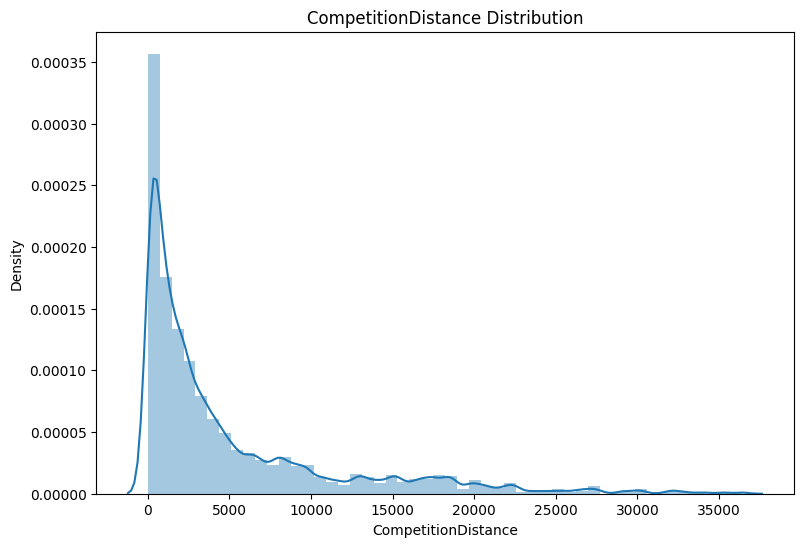

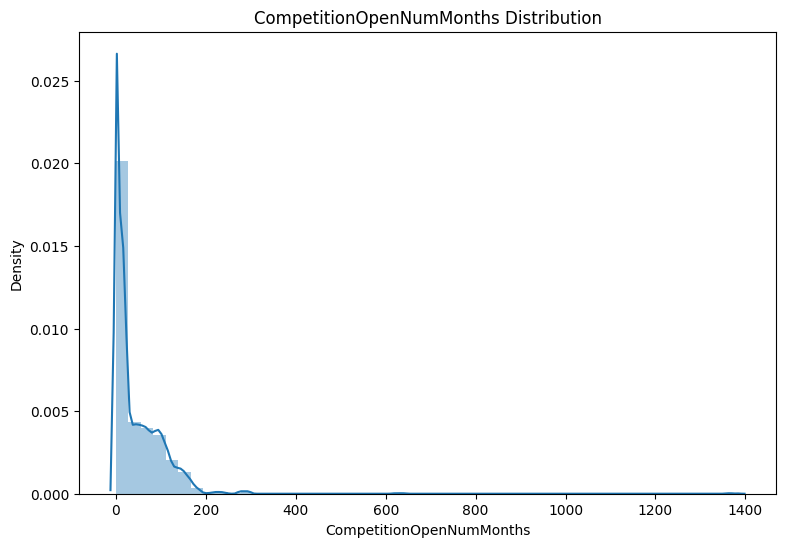

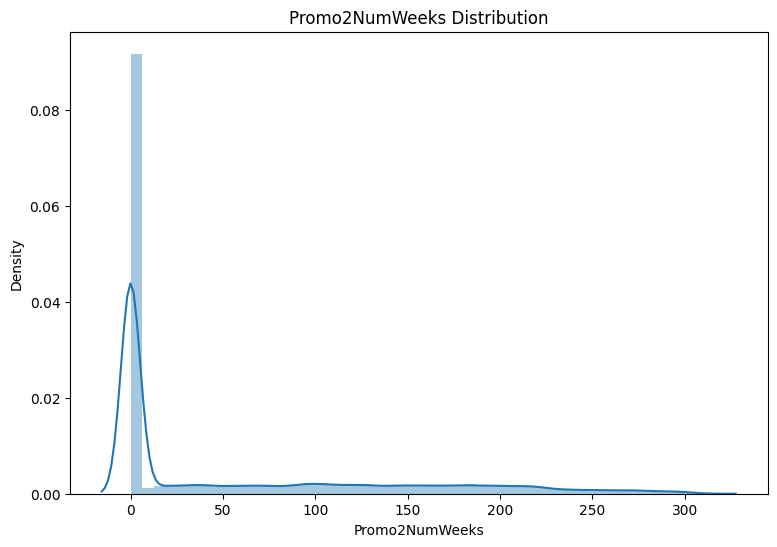

In [ ]:
numerical_features = ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

# generate density plot for numerical features
for feature in numerical_features:
  plt.figure(figsize=(9, 6))
  sns.distplot(df[feature]).set(title=f'{feature} Distribution')
  plt.show()

Sales, customers, competition open number of months and promo 2 number of weeks have zero values while competition distance has only positive values. So sales, customers, competition open number of months and promo 2 number of weeks are square root transformed and competition distance is log transformed.

In [ ]:
df['Sales'] = np.sqrt(df['Sales'])
df['Customers'] = np.sqrt(df['Customers'])
df['CompetitionOpenNumMonths'] = np.sqrt(df['CompetitionOpenNumMonths'])
df['Promo2NumWeeks'] = np.sqrt(df['Promo2NumWeeks'])

# log transformation of competition distance
df['CompetitionDistance'] = np.log(df['CompetitionDistance'])

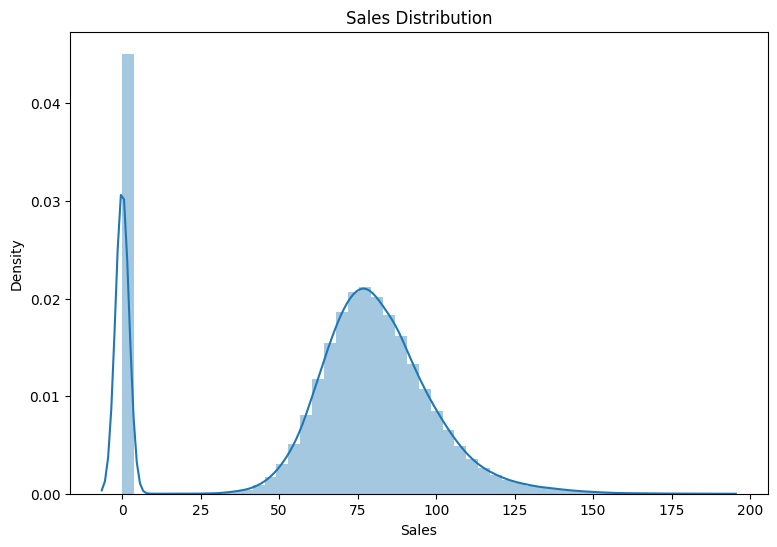

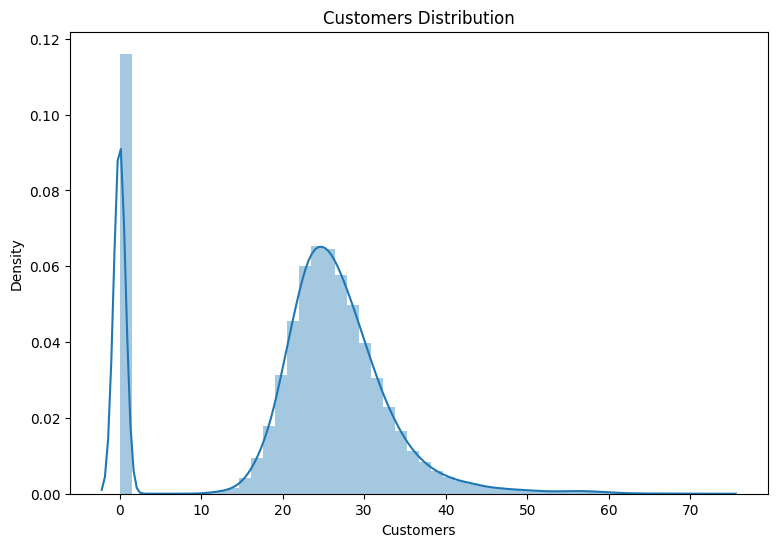

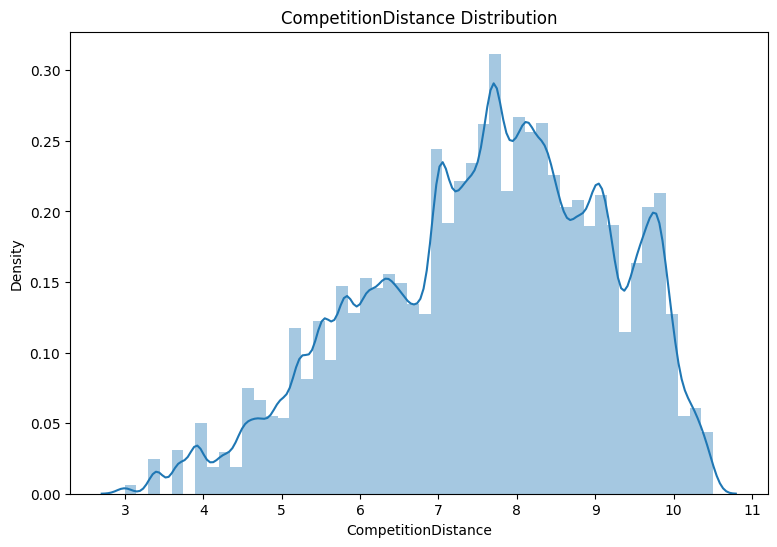

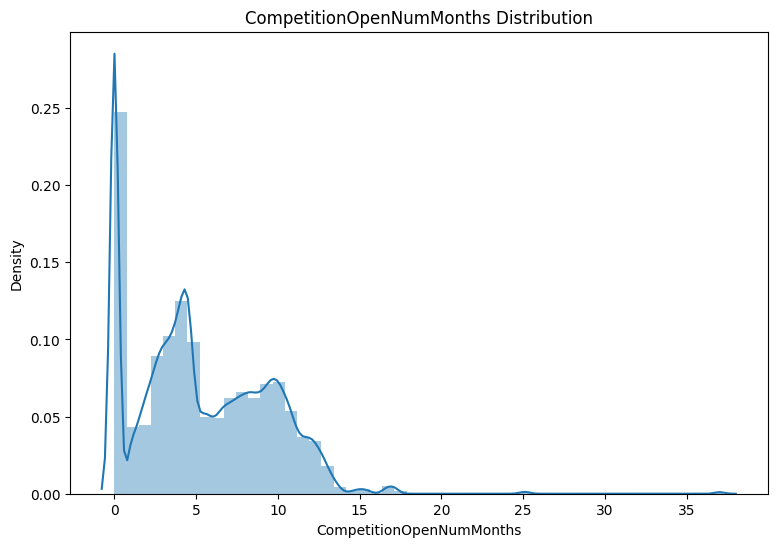

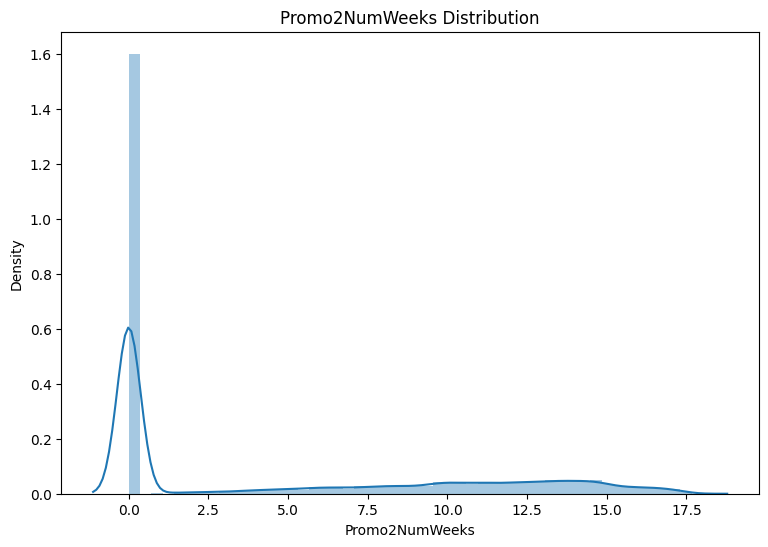

In [ ]:
numerical_features = ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

# generate density plot for numerical features
for feature in numerical_features:
  plt.figure(figsize=(9, 6))
  sns.distplot(df[feature]).set(title=f'{feature} Distribution')
  plt.show()

### **Encoding**

In [ ]:
df = pd.get_dummies(df, columns=['PromoInterval'])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, dtype=int)

ohe.fit(df[['StoreType', 'Assortment']])

encoded_features = list(ohe.get_feature_names_out(['StoreType', 'Assortment']))

encoded_array = ohe.transform(df[['StoreType', 'Assortment']])

for i, col in enumerate(encoded_features):
    df[col] = encoded_array[:, i]

df.drop(['StoreType', 'Assortment'], axis=1, inplace=True)


In [ ]:
df.head()

DayOfWeek       Date       Sales  Customers  Open  Promo  StateHoliday  \
0          5 2015-07-31   72.546537  23.558438     1      1             0   
1          5 2015-07-31   77.871689  25.000000     1      1             0   
2          5 2015-07-31   91.181138  28.653098     1      1             0   
3          5 2015-07-31  118.300465  38.704005     1      1             0   
4          5 2015-07-31   69.440622  23.643181     1      1             0   

   SchoolHoliday  CompetitionDistance  WeekOfYear  ...  \
0              1             7.146772          31  ...   
1              1             6.345636          31  ...   
2              1             9.556055          31  ...   
3              1             6.429719          31  ...   
4              1            10.305948          31  ...   

   PromoInterval_Feb,May,Aug,Nov  PromoInterval_Jan,Apr,Jul,Oct  \
0                          False                          False   
1                          False                           True   
2                          False                           True   
3                          False                          False   
4                          False                          False   

   PromoInterval_Mar,Jun,Sept,Dec  StoreType_a  StoreType_b  StoreType_c  \
0                           False            0            0            1   
1                           False            1            0            0   
2                           False            1            0            0   
3                           False            0            0            1   
4                           False            1            0            0   

   StoreType_d  Assortment_a  Assortment_b  Assortment_c  
0            0             1             0             0  
1            0             1             0             0  
2            0             1             0             0  
3            0             0             0             1  
4            0             1             0             0  

[5 rows x 23 columns]

Using Correlation Matrix to remove one resultant feature to overcome dummy variable trap

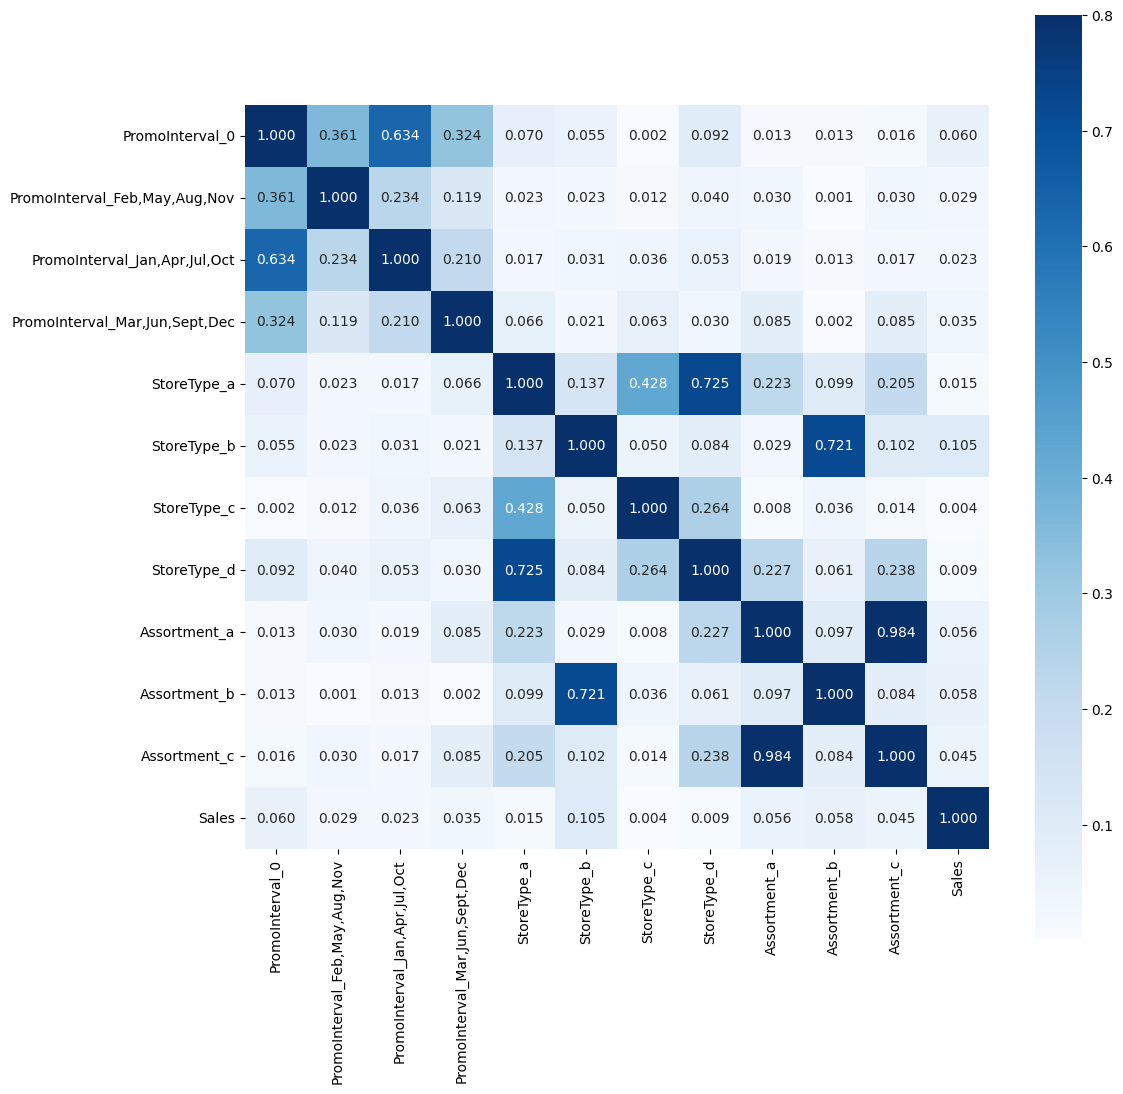

In [ ]:
corr_mat = df.loc[:, ['PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec',
                               'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Sales']].corr().abs()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.3f', annot_kws={'size': 10},  vmax=.8, square=True, cmap="Blues");

PromoInterval_Jan,Apr,Jul,Oct, StoreType_c & Assortment_b have the least correlation to Sales. So, they are removed.

In [ ]:
# drop PromoInterval_Jan,Apr,Jul,Oct, StoreType_c & Assortment_b
df.drop(['PromoInterval_Jan,Apr,Jul,Oct', 'StoreType_c', 'Assortment_b'], axis=1, inplace=True)

In [ ]:
df.head()

DayOfWeek       Date       Sales  Customers  Open  Promo  StateHoliday  \
0          5 2015-07-31   72.546537  23.558438     1      1             0   
1          5 2015-07-31   77.871689  25.000000     1      1             0   
2          5 2015-07-31   91.181138  28.653098     1      1             0   
3          5 2015-07-31  118.300465  38.704005     1      1             0   
4          5 2015-07-31   69.440622  23.643181     1      1             0   

   SchoolHoliday  CompetitionDistance  WeekOfYear  CompetitionOpenNumMonths  \
0              1             7.146772          31                  9.055385   
1              1             6.345636          31                  9.591663   
2              1             9.556055          31                 10.148892   
3              1             6.429719          31                  8.366600   
4              1            10.305948          31                  1.732051   

   Promo2NumWeeks  PromoInterval_0  PromoInterval_Feb,May,Aug,Nov  \
0        0.000000             True                          False   
1       16.673332            False                          False   
2       15.000000            False                          False   
3        0.000000             True                          False   
4        0.000000             True                          False   

   PromoInterval_Mar,Jun,Sept,Dec  StoreType_a  StoreType_b  StoreType_d  \
0                           False            0            0            0   
1                           False            1            0            0   
2                           False            1            0            0   
3                           False            0            0            0   
4                           False            1            0            0   

   Assortment_a  Assortment_c  
0             1             0  
1             1             0  
2             1             0  
3             0             1  
4             1             0

### MODEL TRAINING

In [ ]:
# independant features (input)
X = df.drop(['Sales', 'Customers'], axis=1)

# dependant feature (target)
y = df['Sales']

In [ ]:
# Ensure 'date' is datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Training set: all rows before June 19, 2015
X_train = X[df['Date'] < '2015-06-19']
y_train = y[df['Date'] < '2015-06-19']

# Test set: all rows from June 19, 2015 onward
X_test = X[df['Date'] >= '2015-06-19']
y_test = y[df['Date'] >= '2015-06-19']


In [ ]:
print(df.columns)


Index(['DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'WeekOfYear',
       'CompetitionOpenNumMonths', 'Promo2NumWeeks', 'PromoInterval_0',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Mar,Jun,Sept,Dec',
       'StoreType_a', 'StoreType_b', 'StoreType_d', 'Assortment_a',
       'Assortment_c'],
      dtype='object')


In [ ]:
print('Training shape:', X_train.shape)
print('Test shape:', X_test.shape)

print('Training Min Date:', df.loc[X_train.index, 'Date'].min())
print('Training Max Date:', df.loc[X_train.index, 'Date'].max())
print('\nTest Min Date:', df.loc[X_test.index, 'Date'].min())
print('Test Max Date:', df.loc[X_test.index, 'Date'].max())


Training shape: (960202, 18)
Test shape: (47513, 18)
Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [ ]:
X_train = X_train.drop('Date', axis=1)
X_test = X_test.drop('Date', axis=1)


In [ ]:
# split the datasets to training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

In [ ]:
print(X_train.columns)

Index(['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'CompetitionDistance', 'WeekOfYear', 'CompetitionOpenNumMonths',
       'Promo2NumWeeks', 'PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Mar,Jun,Sept,Dec', 'StoreType_a', 'StoreType_b',
       'StoreType_d', 'Assortment_a', 'Assortment_c'],
      dtype='object')


In [ ]:
print(X_test.columns)

Index(['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'CompetitionDistance', 'WeekOfYear', 'CompetitionOpenNumMonths',
       'Promo2NumWeeks', 'PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Mar,Jun,Sept,Dec', 'StoreType_a', 'StoreType_b',
       'StoreType_d', 'Assortment_a', 'Assortment_c'],
      dtype='object')


### TRYING SOMETHING NEW

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def calculate_rmspe(y_actual, y_pred):
    return (np.sqrt(np.mean(np.square(y_actual.to_numpy() - y_pred))) / np.mean(y_actual.to_numpy())) * 100

def calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred):
    metrics_dict = {}

    metrics_dict['Train_R2'] = r2_score(y_train, y_train_pred)
    metrics_dict['Test_R2'] = r2_score(y_test, y_test_pred)
    metrics_dict['Train_RMSE'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    metrics_dict['Test_RMSE'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    metrics_dict['Train_RMSPE'] = calculate_rmspe(y_train, y_train_pred)
    metrics_dict['Test_RMSPE'] = calculate_rmspe(y_test, y_test_pred)

    return metrics_dict


## Scaling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
metrics_table = pd.DataFrame(columns=['Regression_Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_RMSPE', 'Test_RMSPE'])

In [ ]:
# train data with linear regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# predict the train and test data
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Linear', model_evaluation['Train_R2'], model_evaluation['Test_R2'],
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8348036073940668
RMSE  : 14.07748671266599
RMSPE : 20.847146952429263%

Testing Data
R2    : 0.8237107246051646
RMSE  : 13.563453429632728
RMSPE : 19.203494021181132%


In [ ]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       72.546537  88.045563
1       77.871689  87.083668
2       91.181138  83.809536
3      118.300465  92.899915
4       69.440622  85.248480
...           ...        ...
47508   74.953319  84.206802
47509  106.018866  90.810916
47510   84.344532  89.478774
47511  147.763324  91.730321
47512   91.054928  84.818817

[47513 rows x 2 columns]

### Ridge Regression with Hyperparameter Tuning

In [ ]:
# train data with ridge regression
ridge = Ridge()
parameters = {'alpha':[1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5]}

# GridSearchCV is used for hyperparameter tuning because Ridge() have only one hyperparameter
# cv=3 since dataset is large
ridge_reg = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for ridge regression: ")
for key, value in ridge_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {ridge_reg.best_score_}")

# predict the train and test data
y_train_pred = ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test)

The best parameters for ridge regression: 
alpha=5

Negative mean squared error: -200.3735064999852


In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Ridge', model_evaluation['Train_R2'], model_evaluation['Test_R2'],
                                                        model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],
                                                        model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]


Training Data
R2    : 0.8348036070229814
RMSE  : 14.077486728477325
RMSPE : 20.847146975844037%

Testing Data
R2    : 0.8237112112156774
RMSE  : 13.563434710049341
RMSPE : 19.203467517502734%


In [ ]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       72.546537  88.045469
1       77.871689  87.083491
2       91.181138  83.809365
3      118.300465  92.899743
4       69.440622  85.248368
...           ...        ...
47508   74.953319  84.206643
47509  106.018866  90.810721
47510   84.344532  89.478560
47511  147.763324  91.730106
47512   91.054928  84.818574

[47513 rows x 2 columns]

### Decision Tree Regression with Hyperparameter Tuning

In [ ]:
# train data with decision tree regression
decision_tree = DecisionTreeRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because DecisionTreeRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
dt_reg = RandomizedSearchCV(estimator=decision_tree, param_distributions=parameters, n_iter=10, cv=3)
dt_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for decision tree regression: ")
for key, value in dt_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {dt_reg.best_score_}")

# predict the train and test data
y_train_pred = dt_reg.predict(X_train)
y_test_pred = dt_reg.predict(X_test)

The best parameters for decision tree regression: 
min_samples_split=2
min_samples_leaf=1
max_leaf_nodes=20
max_features=sqrt
max_depth=None

Negative mean squared error: 0.8314155167074628


In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Decision Tree', model_evaluation['Train_R2'], model_evaluation['Test_R2'],
                                                                model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],
                                                                model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8051544087741533
RMSE  : 15.288685188189245
RMSPE : 22.64079329876701%

Testing Data
R2    : 0.8206436798876215
RMSE  : 13.680931759749647
RMSPE : 19.369822930092326%


In [ ]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       72.546537  87.114449
1       77.871689  87.114449
2       91.181138  87.114449
3      118.300465  92.360796
4       69.440622  87.114449
...           ...        ...
47508   74.953319  87.114449
47509  106.018866  92.360796
47510   84.344532  92.360796
47511  147.763324  92.360796
47512   91.054928  80.612621

[47513 rows x 2 columns]

### Random Forest Regression with Hyperparameter Tuning

In [ ]:
# train data with random forest regression
random_forest = RandomForestRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because RandomForestRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
rf_reg = RandomizedSearchCV(estimator=random_forest, param_distributions=parameters, n_iter=10, cv=3)
rf_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for random forest regression: ")
for key, value in rf_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {rf_reg.best_score_}")

# predict the train and test data
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

The best parameters for random forest regression: 
min_samples_split=5
min_samples_leaf=2
max_leaf_nodes=100
max_features=sqrt
max_depth=None

Negative mean squared error: 0.8580233860361787


In [ ]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Random Forest', model_evaluation['Train_R2'], model_evaluation['Test_R2'],
                                                                model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],
                                                                model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8630218519088134
RMSE  : 12.818892088133659
RMSPE : 18.983312332890552%

Testing Data
R2    : 0.8451537686653486
RMSE  : 12.71181764590454
RMSPE : 17.997725684533332%


In [ ]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       72.546537  86.191908
1       77.871689  82.686895
2       91.181138  84.080798
3      118.300465  89.931383
4       69.440622  79.725308
...           ...        ...
47508   74.953319  82.227690
47509  106.018866  90.640276
47510   84.344532  88.746071
47511  147.763324  90.842733
47512   91.054928  84.510577

[47513 rows x 2 columns]

### XGBoost Regression with Hyperparameter Tuning

In [ ]:
# train data with XGBoost regression
xgboost = xgb.XGBRegressor(objective='reg:linear', verbosity=0)
parameters = {'max_depth': [2, 5, 10],
              'learning_rate': [0.05, 0.1, 0.2],
              'min_child_weight': [1, 2, 5],
              'gamma': [0, 0.1, 0.3],
              'colsample_bytree': [0.3, 0.5, 0.7]}

# RandomizedSearchCV is used for hyperparameter tuning because XGBRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
xg_reg = RandomizedSearchCV(estimator=xgboost, param_distributions=parameters, n_iter=10, cv=3)
xg_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for XGBoost regression: ")
for key, value in xg_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {xg_reg.best_score_}")

# predict the train and test data
y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)



# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['XGBoost', model_evaluation['Train_R2'], model_evaluation['Test_R2'],
                                                          model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],
                                                          model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

The best parameters for XGBoost regression: 
min_child_weight=5
max_depth=10
learning_rate=0.05
gamma=0.3
colsample_bytree=0.7

Negative mean squared error: 0.9002489258832341
Training Data
R2    : 0.9187635343384575
RMSE  : 9.871891116212721
RMSPE : 14.61914111507572%

Testing Data
R2    : 0.8937987506500489
RMSE  : 10.527424783099073
RMSPE : 14.905004830038433%


In [ ]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual        pred
0       72.546537   82.422775
1       77.871689   81.638229
2       91.181138   84.048470
3      118.300465   93.740479
4       69.440622   77.343735
...           ...         ...
47508   74.953319   83.100098
47509  106.018866   93.997818
47510   84.344532   89.621803
47511  147.763324  107.777931
47512   91.054928   86.598816

[47513 rows x 2 columns]

### LightGBM Regression with Hyperparameter Tuning

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

# Instantiate the LightGBM regressor
lightgbm = LGBMRegressor(objective='regression', verbosity=-1)

# Define the hyperparameter grid
parameters = {
    'max_depth': [2, 5, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 2, 5],  # LightGBM uses 'min_child_samples' instead, you may adjust if needed
    'num_leaves': [15, 31, 63],
    'colsample_bytree': [0.3, 0.5, 0.7]
}
# Use RandomizedSearchCV for hyperparameter tuning
lgbm_reg = RandomizedSearchCV(
    estimator=lightgbm,
    param_distributions=parameters,
    n_iter=10,
    cv=3
)
lgbm_reg.fit(X_train, y_train)


print("The best parameters for LightGBM regression: ")
for key, value in lgbm_reg.best_params_.items():
    print(f"{key}={value}")
print(f"\nNegative mean squared error: {lgbm_reg.best_score_}")

y_train_pred = lgbm_reg.predict(X_train)
y_test_pred = lgbm_reg.predict(X_test)

# Assuming calculate_model_metrics is already defined
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# Print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")


metrics_table.loc[len(metrics_table.index)] = [
    'LightGBM',
    model_evaluation['Train_R2'], model_evaluation['Test_R2'],
    model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'],
    model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']
]


The best parameters for LightGBM regression: 
num_leaves=63
min_child_weight=2
max_depth=10
learning_rate=0.1
colsample_bytree=0.3

Negative mean squared error: 0.8918022071834905
Training Data
R2    : 0.9074967579384783
RMSE  : 10.534242786872984
RMSPE : 15.600008147258237%

Testing Data
R2    : 0.885773065391313
RMSE  : 10.917962425774475
RMSPE : 15.457938293855126%


### Trying With Test Dataset